In [89]:
import numpy as np
import torch
from torch.autograd import Variable

import matplotlib.pyplot as plt
from graphviz import Digraph

%matplotlib inline

[DEBUG:55127 pyplot:225 2019-12-31 23:03:37,331] Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [116]:
def create_env_det(env_name, full_action_space=False, noop=20):
    return atari_wrappers.wrap_pytorch(
        atari_wrappers.wrap_deepmind(
            atari_wrappers.make_atari_det(env_name, full_action_space=full_action_space, noop=noop),
            clip_rewards=False,
            frame_stack=True,
            scale=False,
        )
    )

In [54]:
def make_dot(var, params=None):
    """ Produces Graphviz representation of PyTorch autograd graph

    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function

    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    if params is not None:
        #assert all(isinstance(p, Variable) for p in params.values())        
        param_map = {id(v): k for k, v in params.items()}


    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()

    def size_to_str(size):
        return '('+(', ').join(['%d' % v for v in size])+')'

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                u = var.variable
                #name = param_map[id(u)] if params is not None else ''
                #node_name = '%s\n %s' % (name, size_to_str(u.size()))
                node_name = '%s\n %s' % (param_map.get(id(u.data)), size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
                
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var.grad_fn)
    return dot


def custom_viz(kernels, path=None, cols=None):
    """
    Visualize weight and activation matrices learned 
    during the optimization process. Works for any size of kernels.
    
    Arguments
    =========
    kernels: Weight or activation matrix. Must be a high dimensional
    Numpy array. Tensors will not work.
    path: Path to save the visualizations.
    cols: TODO: Number of columns (doesn't work completely yet.)
    
    Example
    =======
    kernels = model.conv1.weight.cpu().detach().clone()
    kernels = kernels - kernels.min()
    kernels = kernels / kernels.max()
    custom_viz(kernels, 'results/conv1_weights.png', 5)
    """
    def set_size(w,h, ax=None):
        # w, h: width, height in inches 
        if not ax: ax=plt.gca()
        l = ax.figure.subplotpars.left
        r = ax.figure.subplotpars.right
        t = ax.figure.subplotpars.top
        b = ax.figure.subplotpars.bottom
        figw = float(w)/(r-l)
        figh = float(h)/(t-b)
        ax.figure.set_size_inches(figw, figh)
    
    N = kernels.shape[0]
    C = kernels.shape[1]

    Tot = N*C

    # If single channel kernel with HxW size,# plot them in a row.# Else, plot image with C number of columns.
    if C>1:
        columns = C
    elif cols==None:
        columns = N
    elif cols:
        columns = cols
    rows = Tot // columns 
    rows += Tot % columns

    pos = range(1,Tot + 1)

    fig = plt.figure(1)
    fig.tight_layout()
    k=0
    for i in range(kernels.shape[0]):
        for j in range(kernels.shape[1]):
            img = kernels[i][j]
            ax = fig.add_subplot(rows,columns,pos[k])
            ax.imshow(img, cmap='gray')
            plt.axis('off')
            k = k+1

    set_size(30,30,ax)
    if path:
        plt.savefig(path, dpi=100)
    
    plt.show()

In [192]:
def hook_fn(m, i, o):
    visualisation[m] = o 

def get_all_layers(net):
    for name, layer in net._modules.items():
        if type(layer) == torch.nn.Sequential or type(layer) == torch.nn.ModuleList:
            get_all_layers(layer)
        else:
            layer.register_forward_hook(hook_fn)

In [117]:
import sys
sys.path.insert(0, '../')
from torchbeast.polybeast import Net
from torchbeast.polybeast import PopArtLayer
from torchbeast import atari_wrappers
from torchbeast.core.environment import Environment

In [216]:
model = Net(num_actions=6, num_tasks=6, use_lstm=False, use_popart=True, reward_clipping="abs_one")
print(model.parameters)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

<bound method Module.parameters of Net(
  (feat_convs): ModuleList(
    (0): Sequential(
      (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
  )
  (resnet1): ModuleList(
    (0): Sequential(
      (0): ReLU()
      (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU()
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): Sequential(
      (0): ReLU()
      (1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
 

In [217]:
layers = []
i = 0
for module in model.modules():
    if type(module) != torch.nn.Sequential\
        and type(module) != torch.nn.Module\
        and type(module) != torch.nn.ModuleList\
        and type(module) != torch.nn.ReLU\
        and type(module) != torch.nn.MaxPool2d\
        and type(module) != PopArtLayer\
        and i > 0:
        layers.append(module)
    i = i + 1
layers

[Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1)

In [218]:
model = Net(num_actions=6, num_tasks=1, use_lstm=False, use_popart=True, reward_clipping="abs_one")
model.eval()
checkpointpath = '../logs/torchbeast/MultiTask/model.tar'
checkpoint = torch.load(checkpointpath, map_location="cpu")
if 'baseline.mu' not in checkpoint["model_state_dict"]:
    checkpoint["model_state_dict"]["baseline.mu"] = torch.zeros(1)
    checkpoint["model_state_dict"]["baseline.sigma"] = torch.ones(1)
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

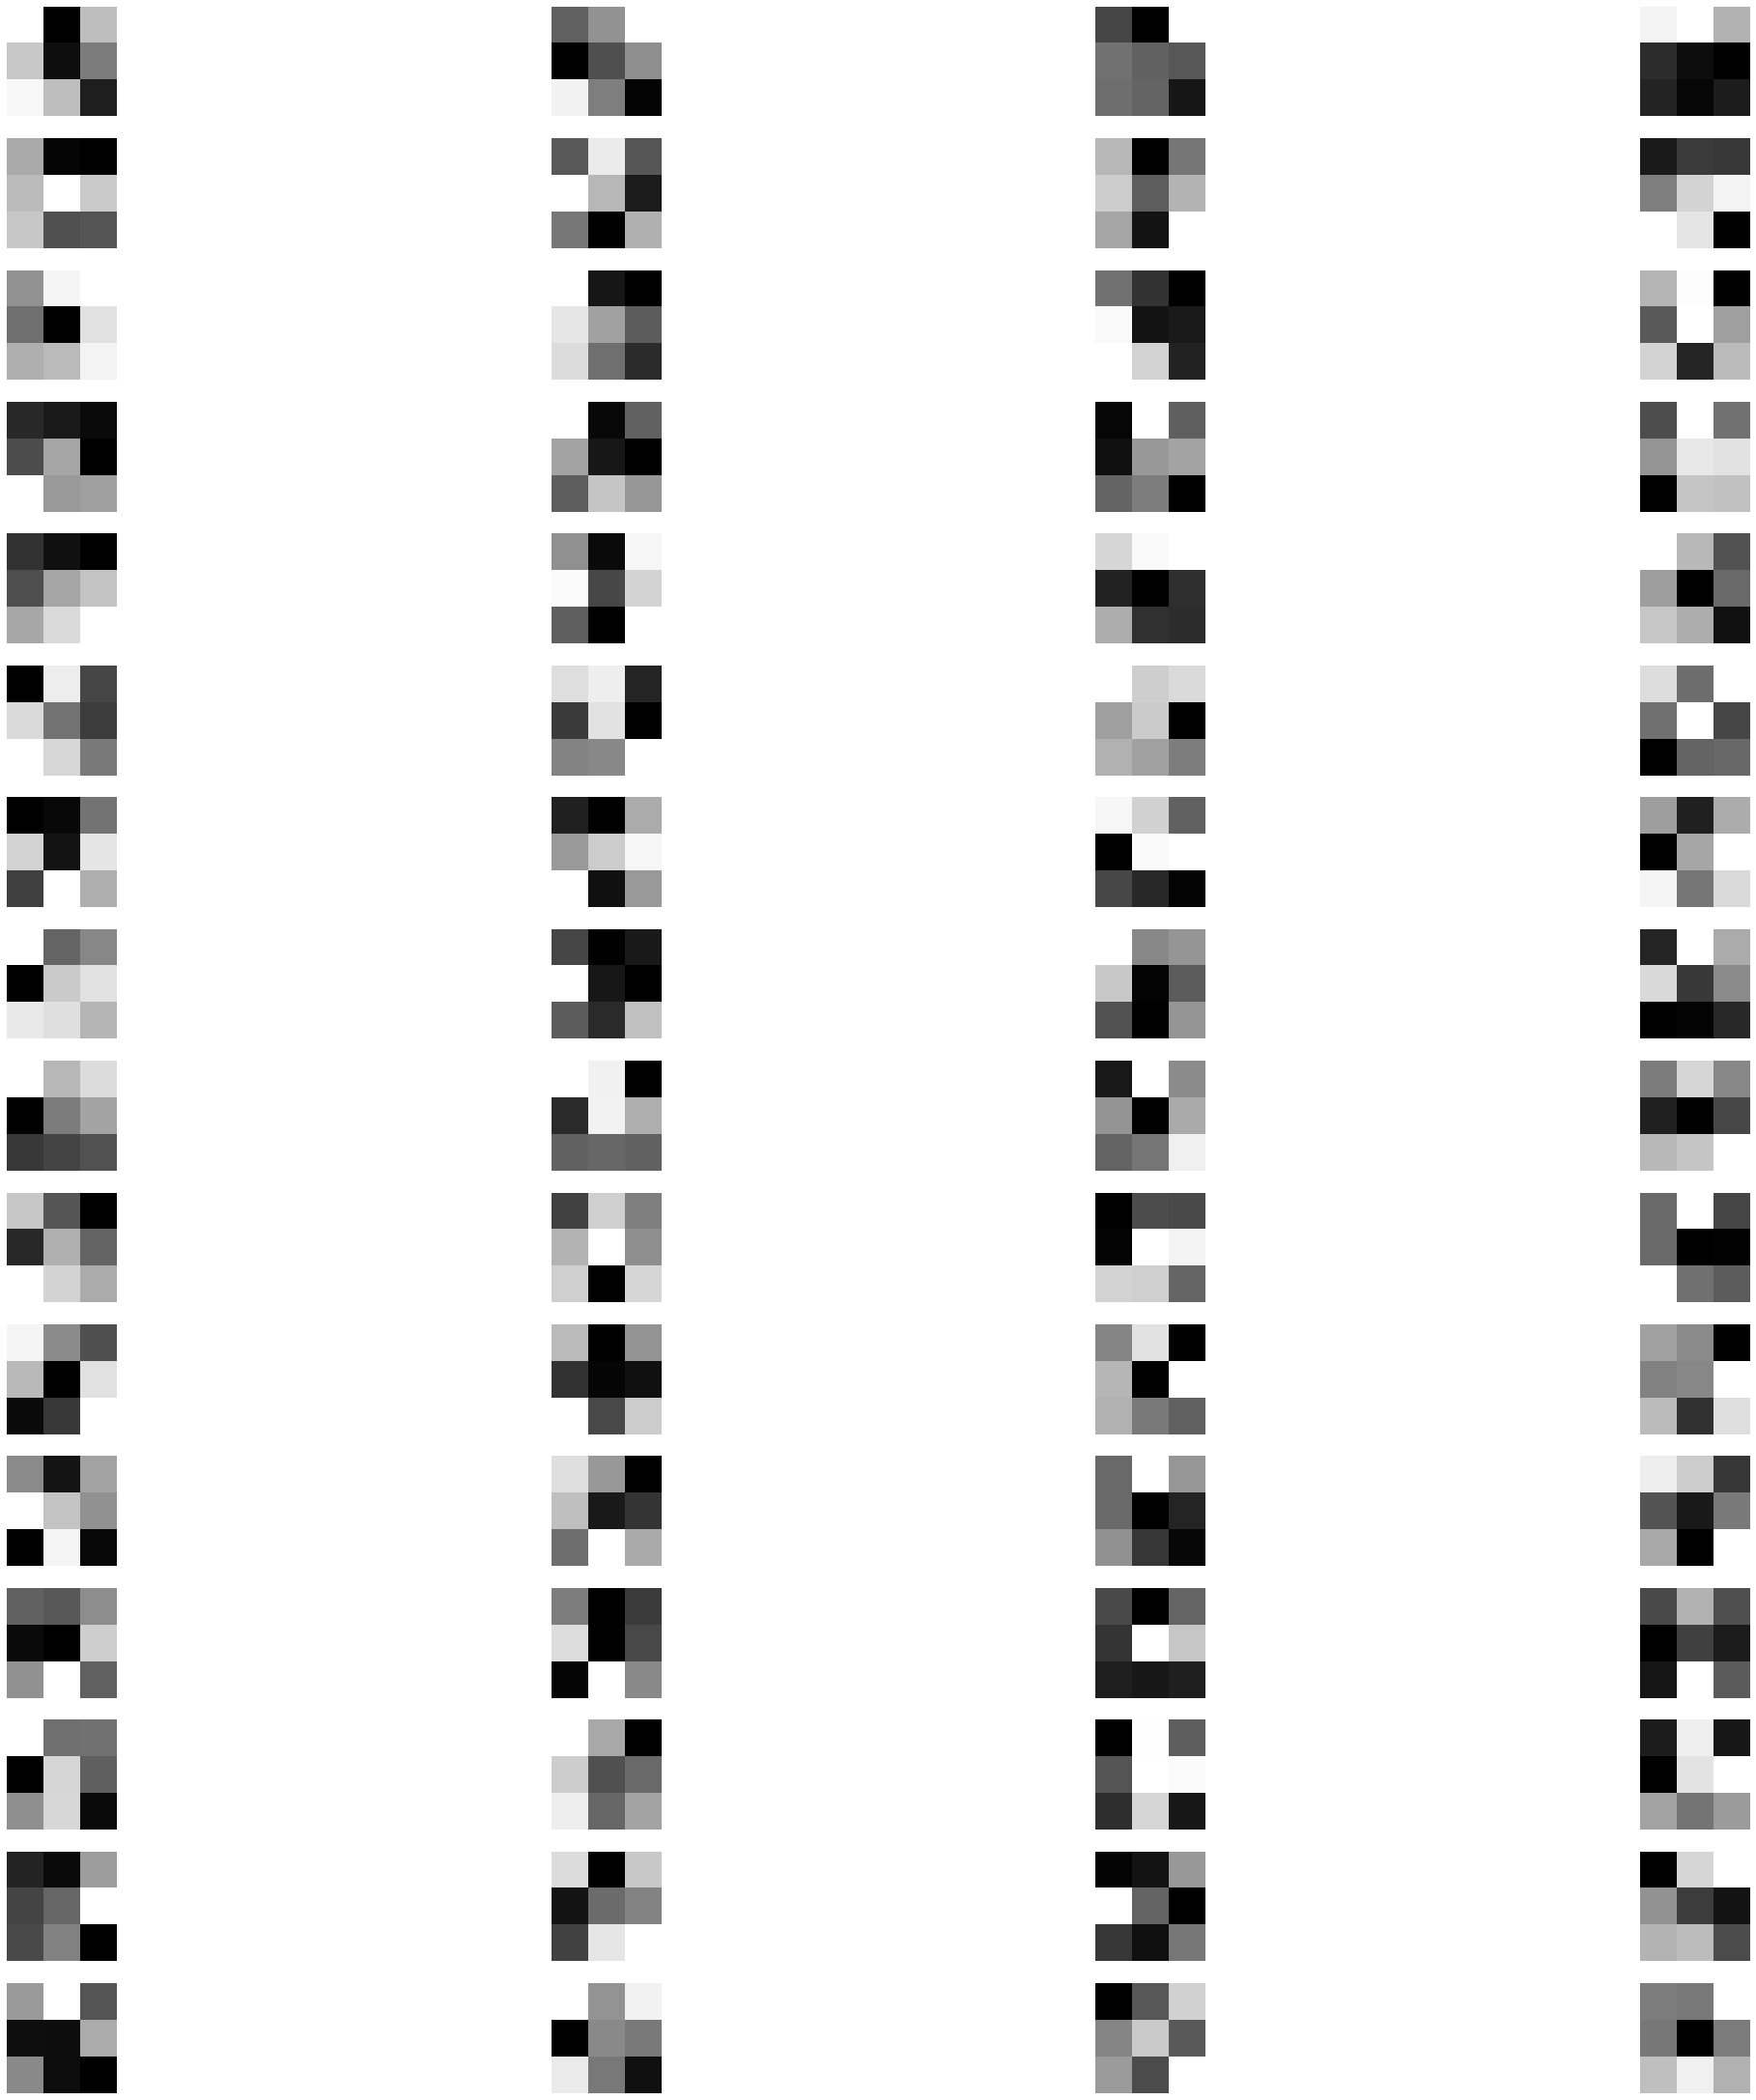

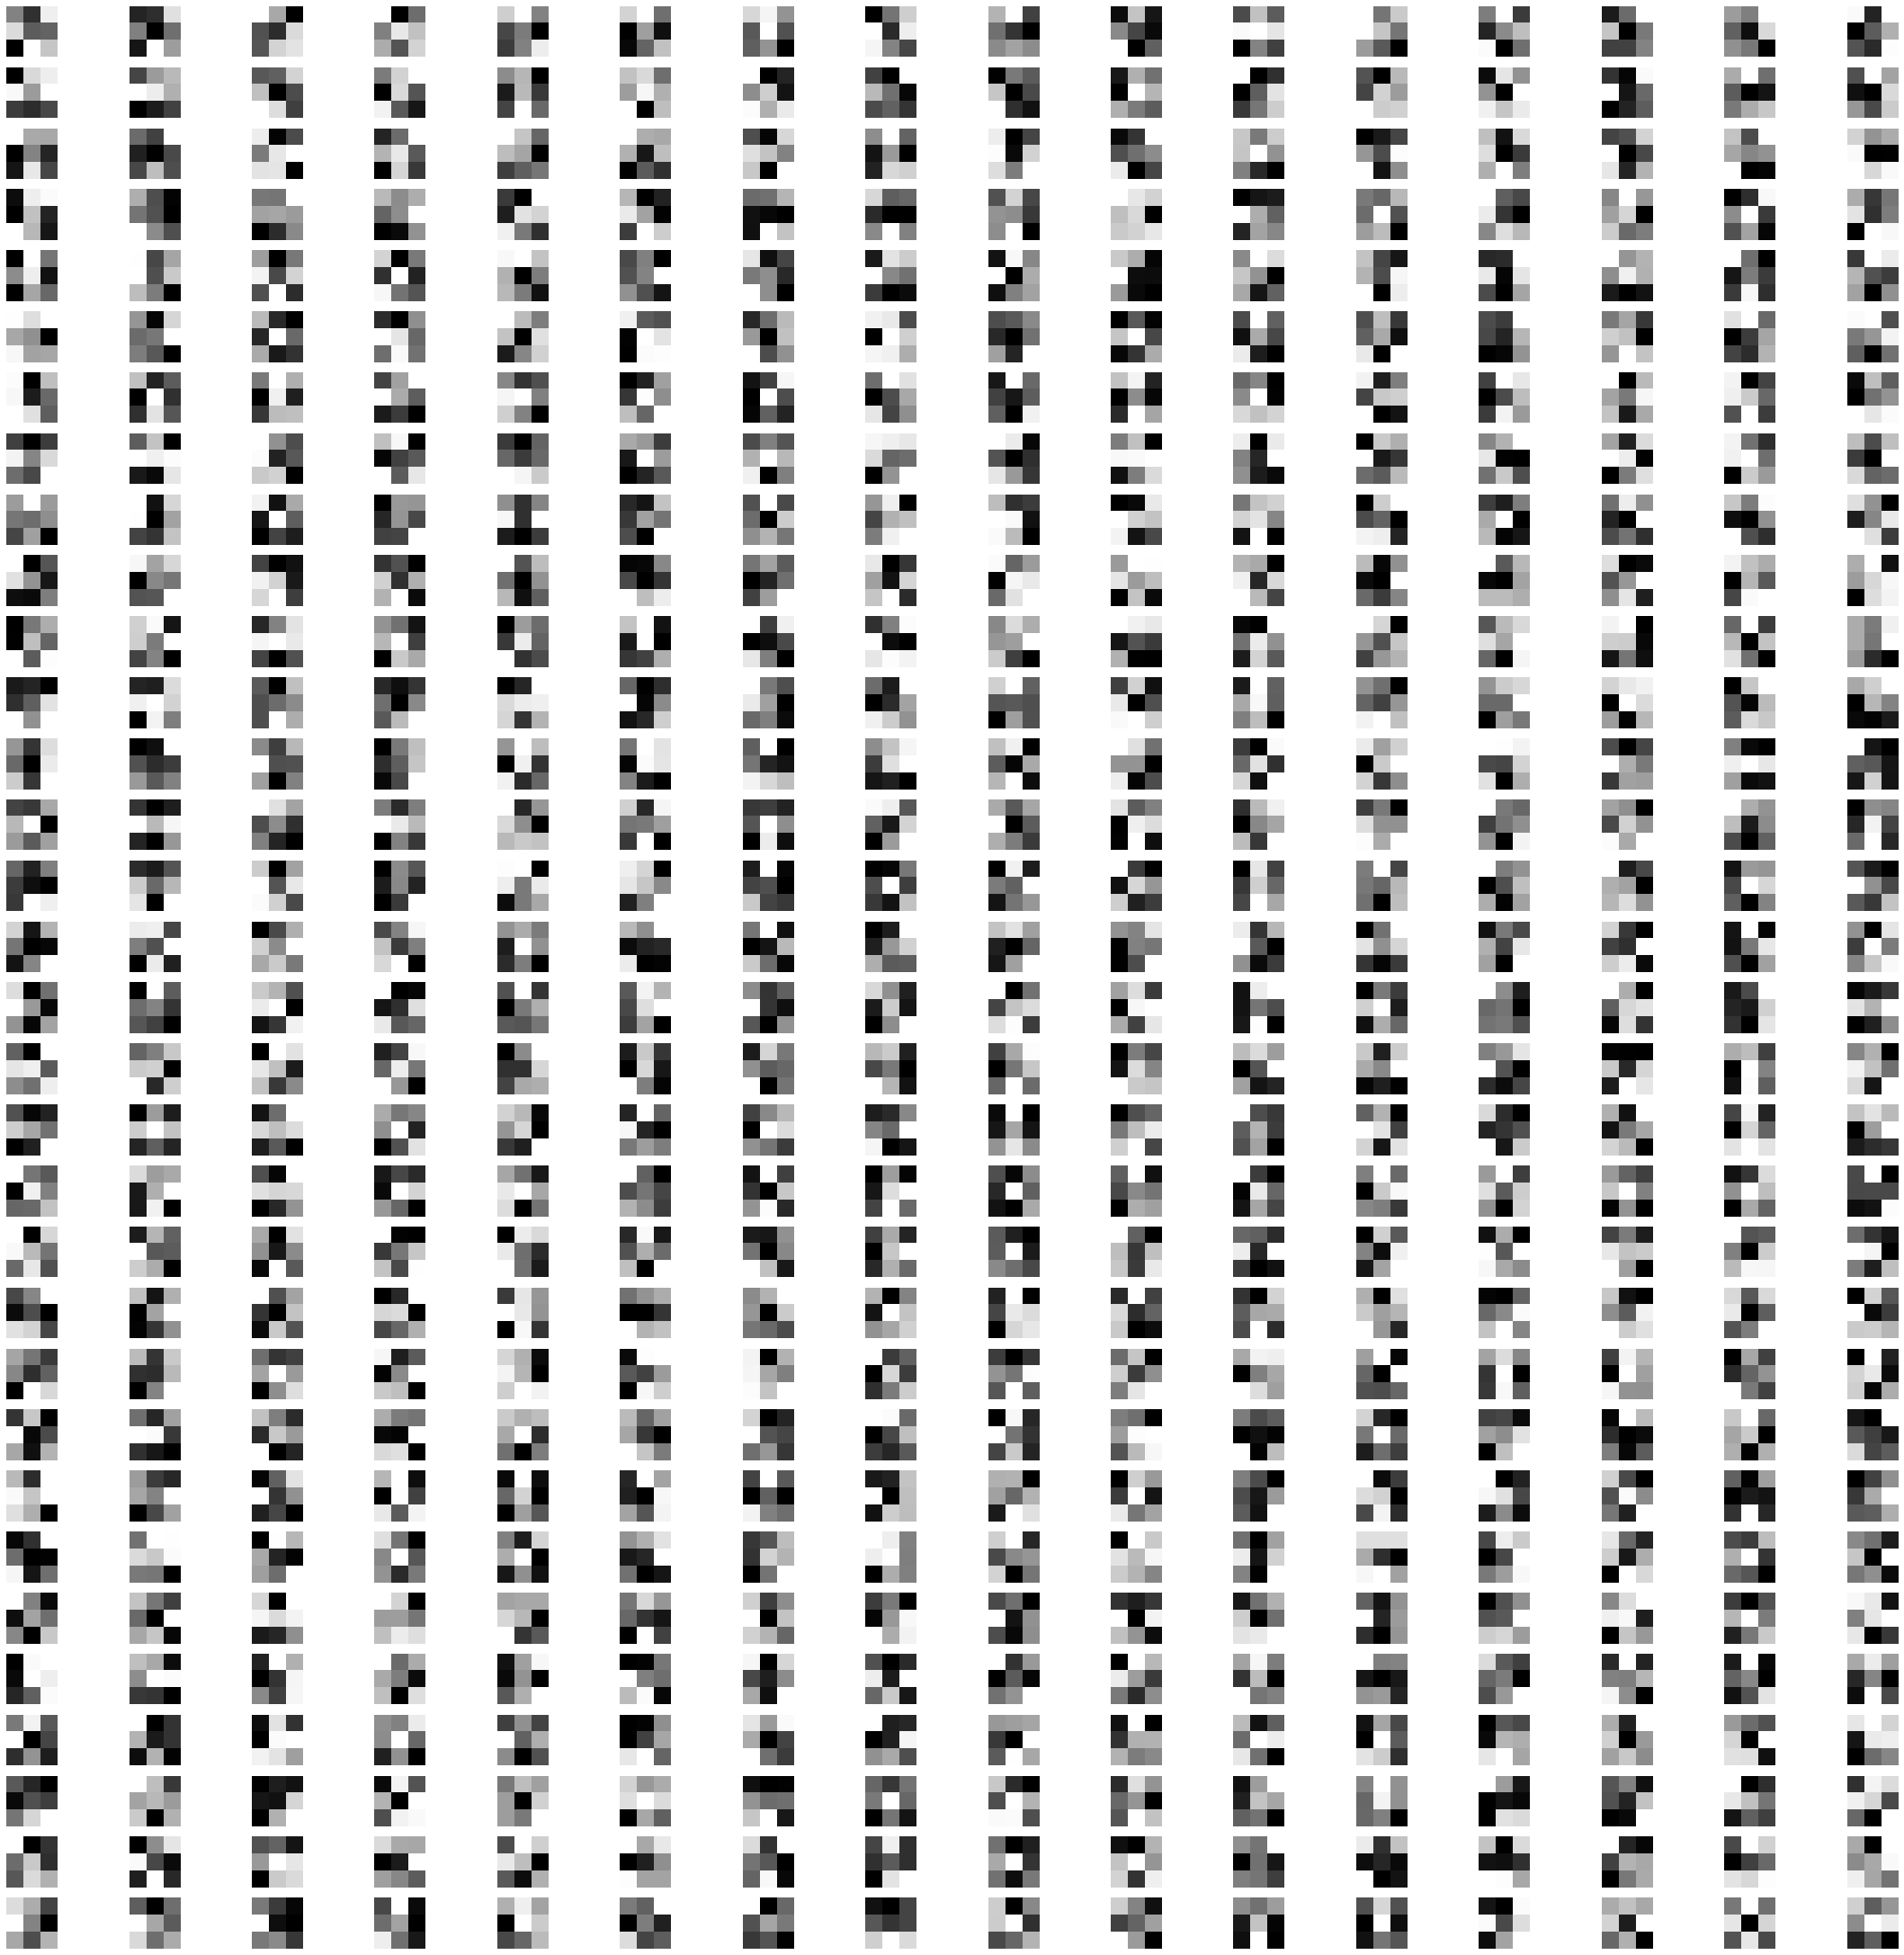

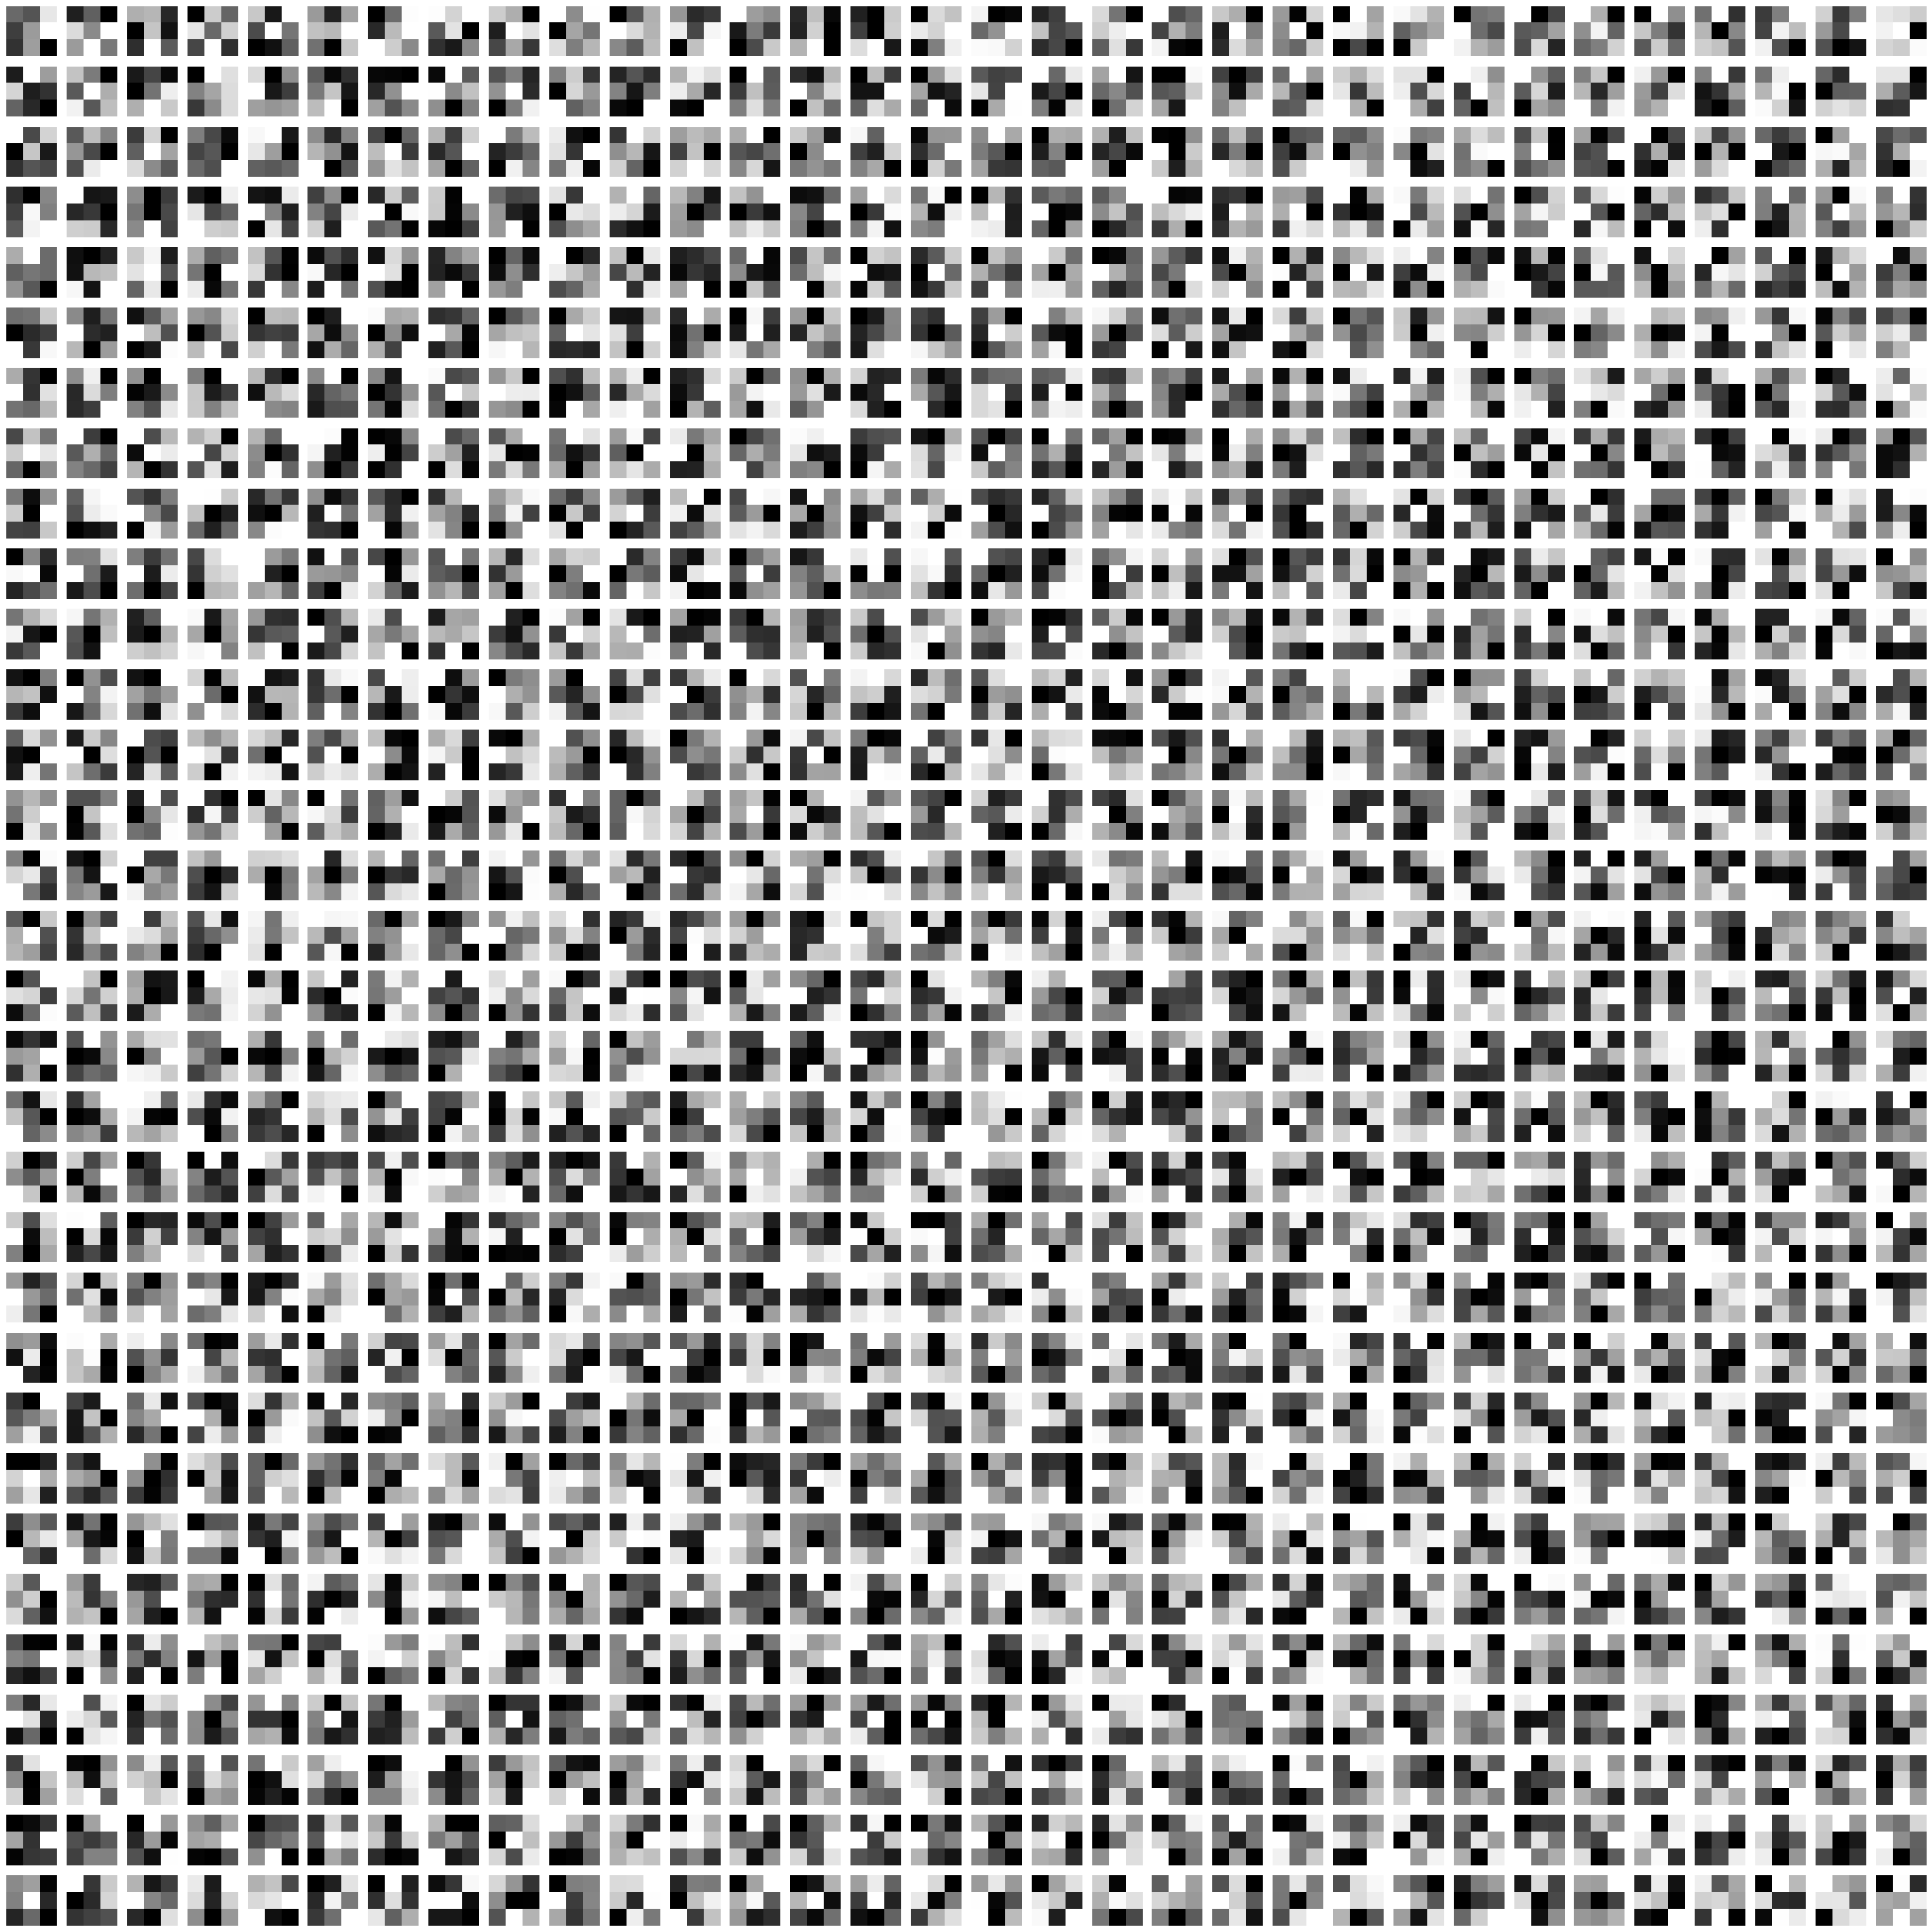

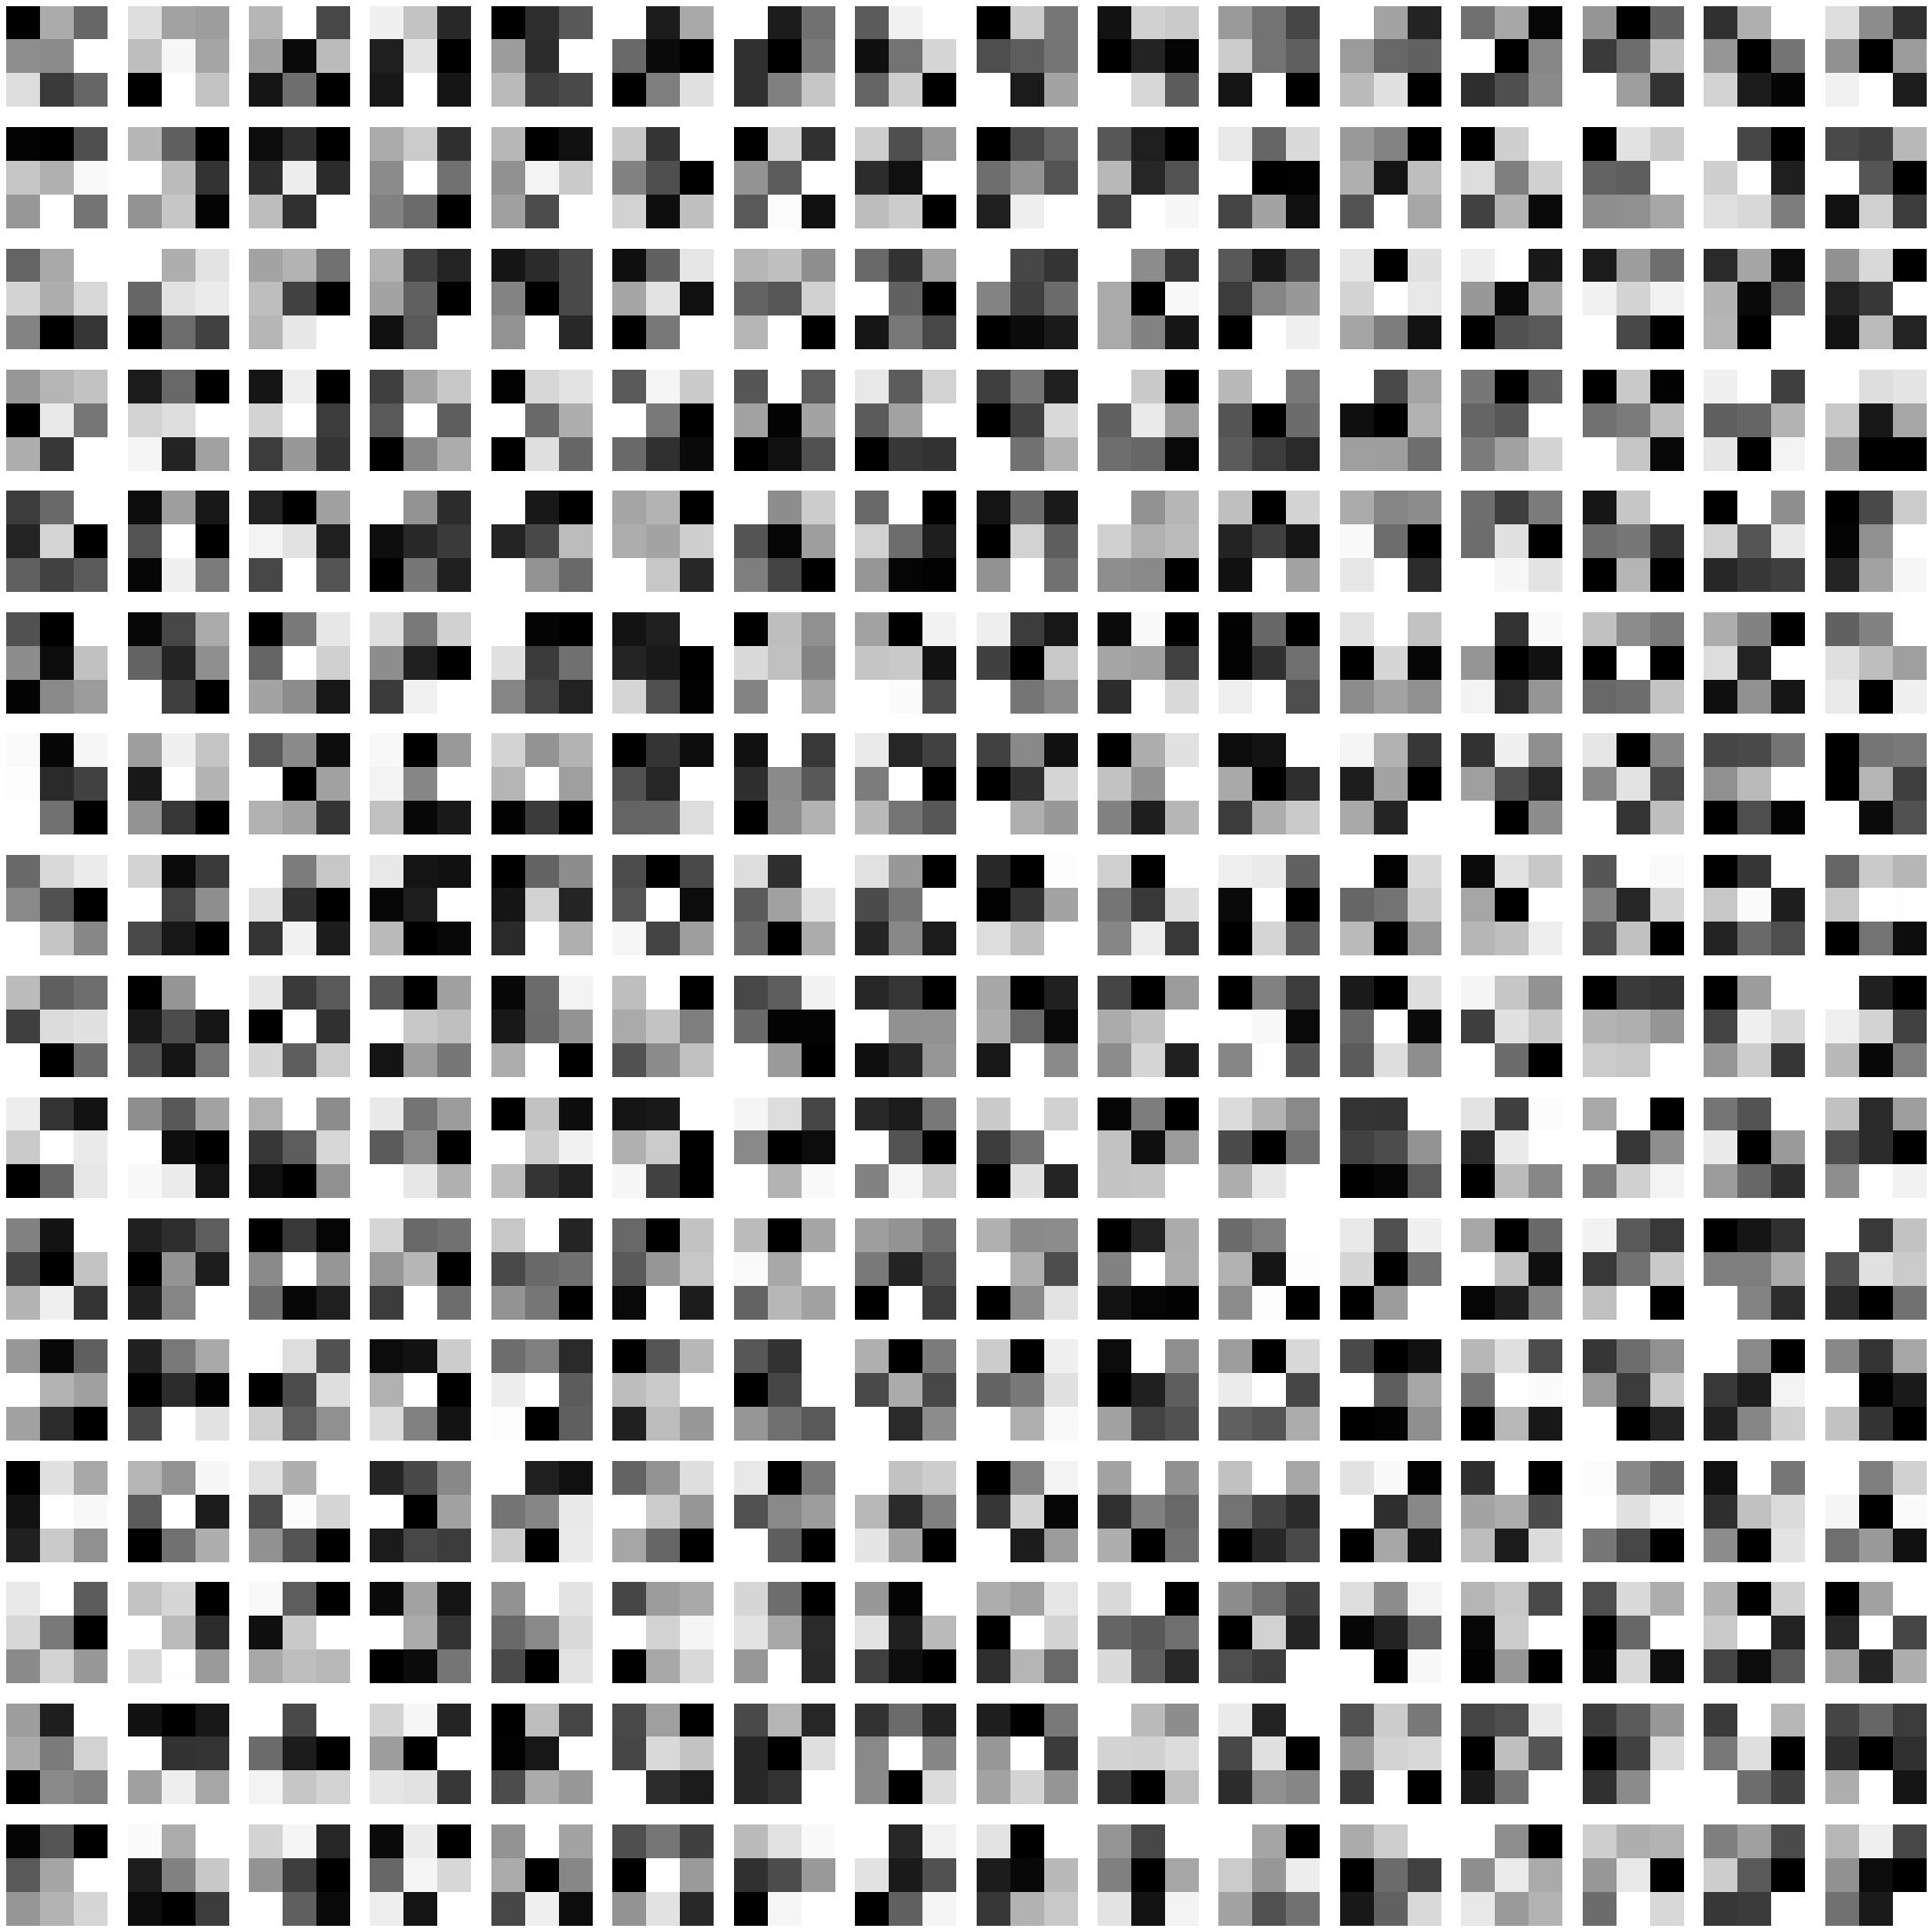

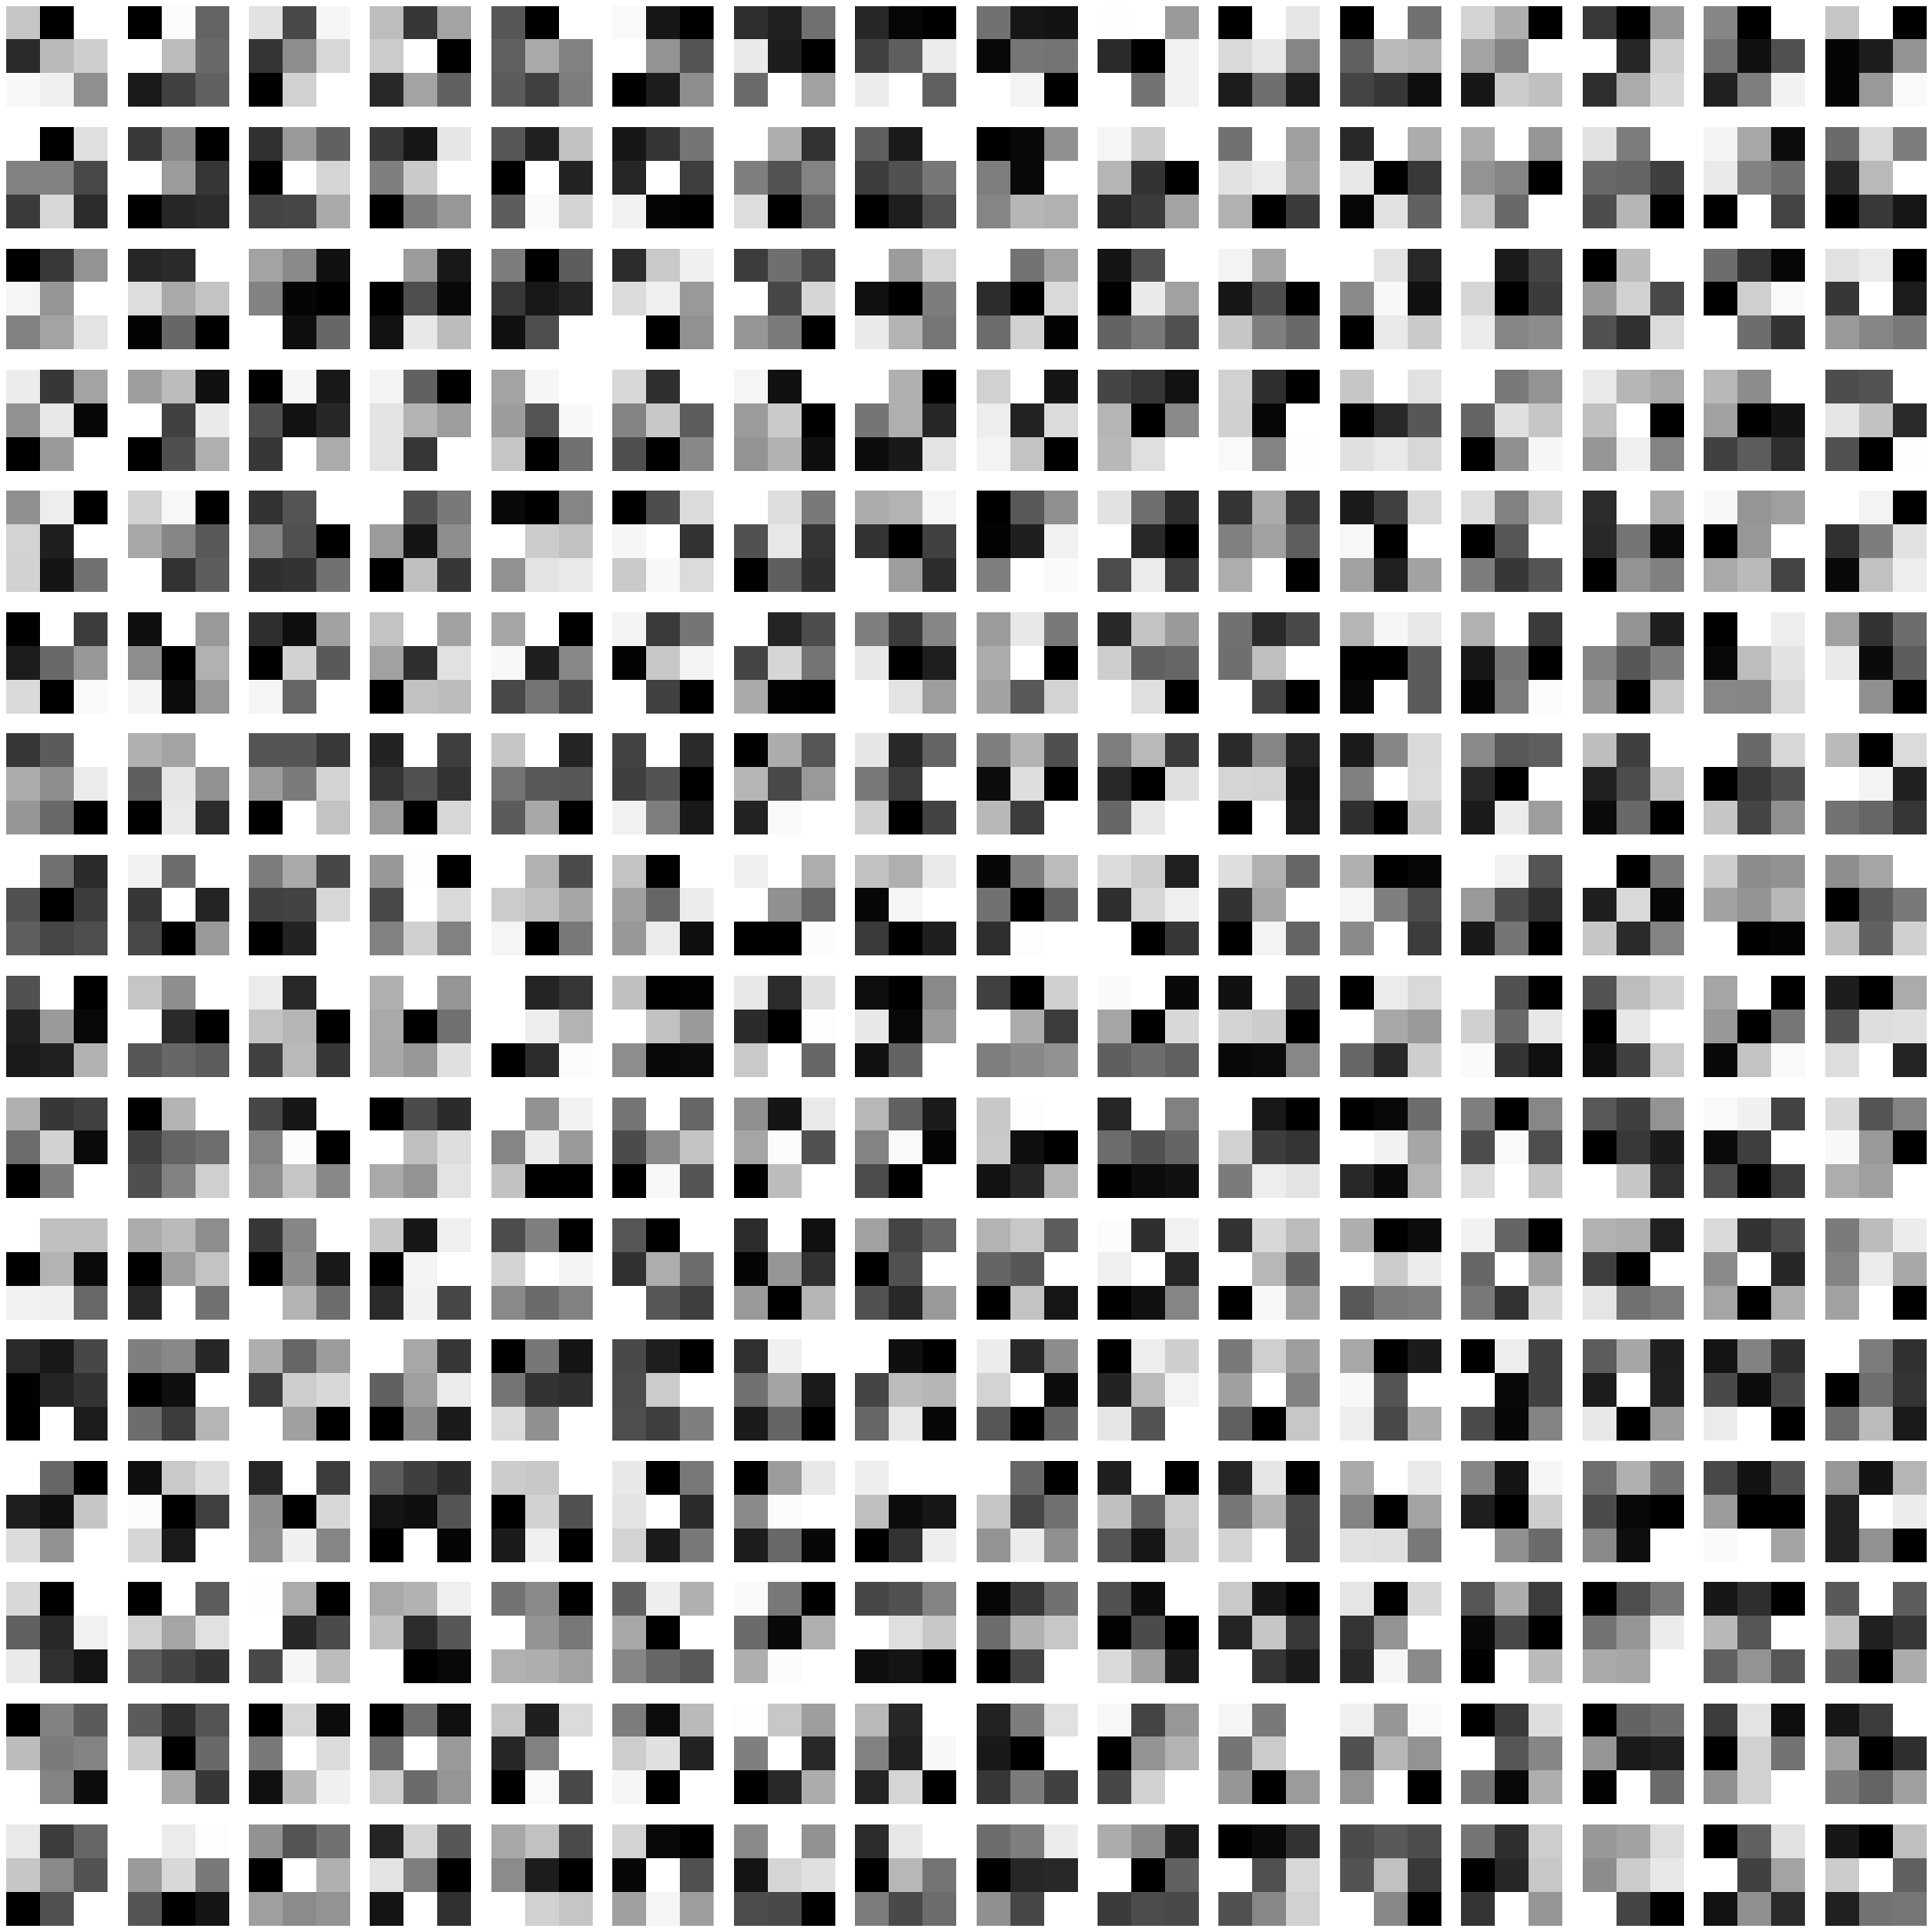

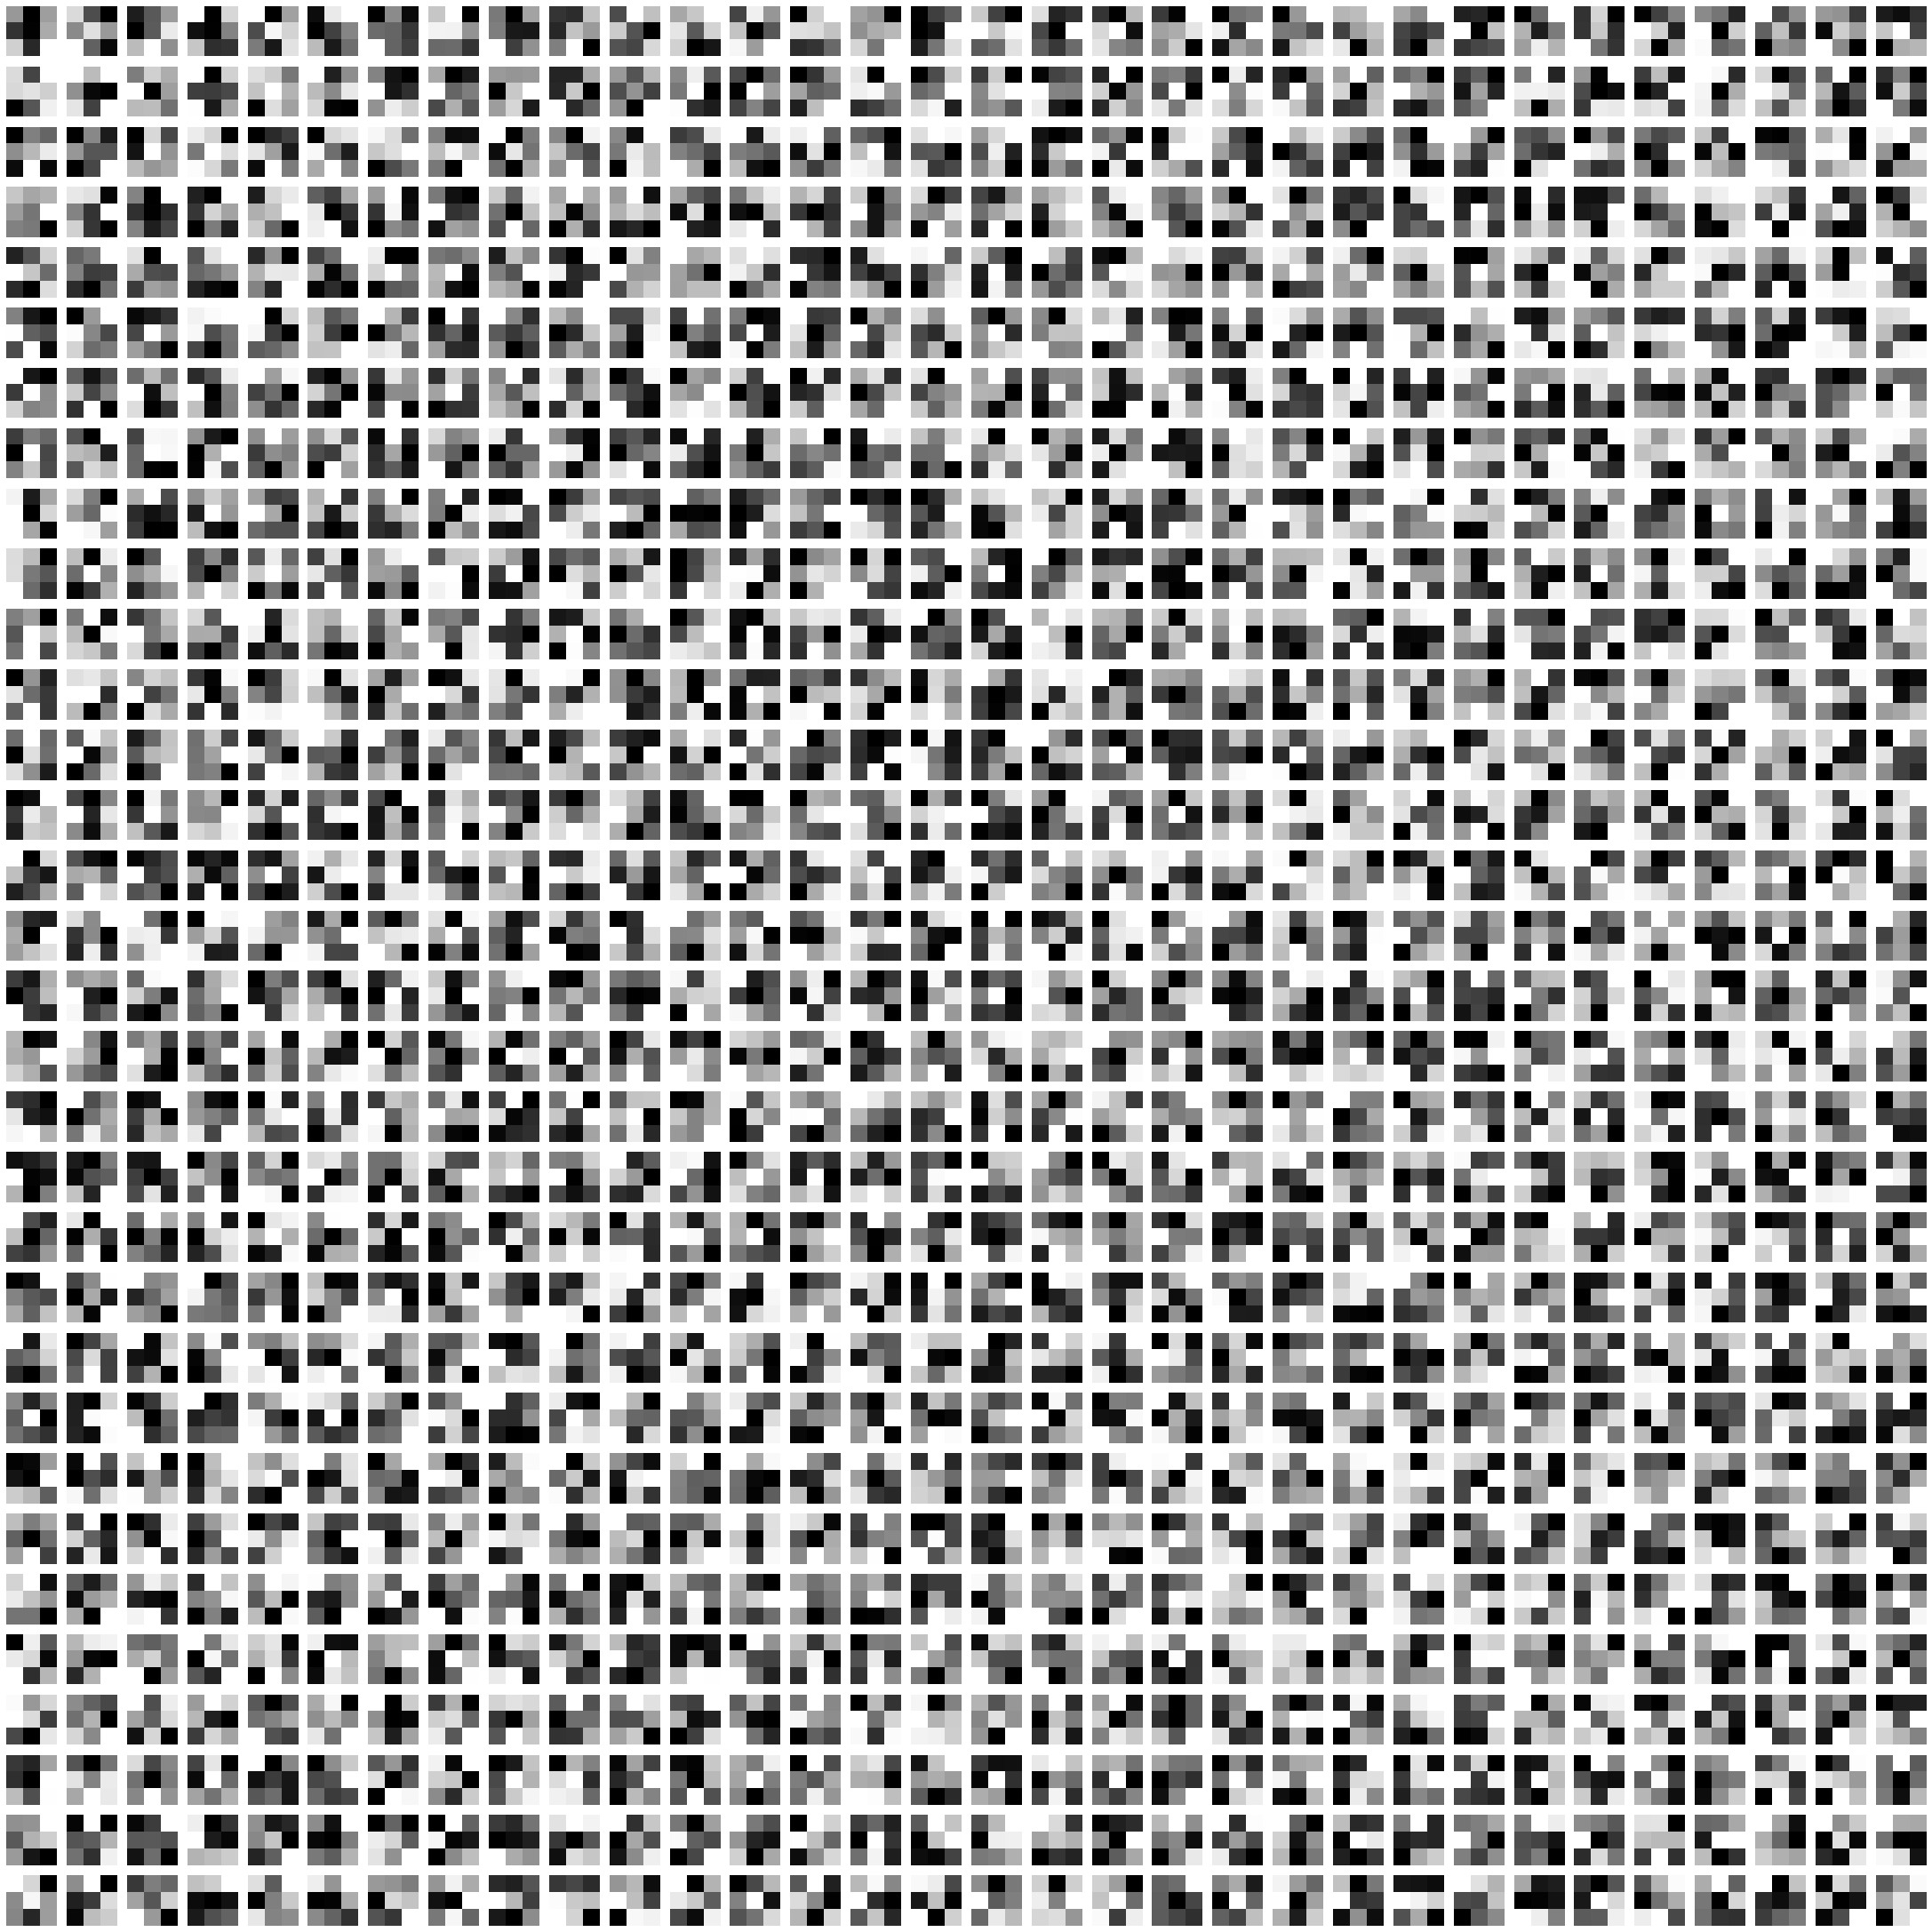

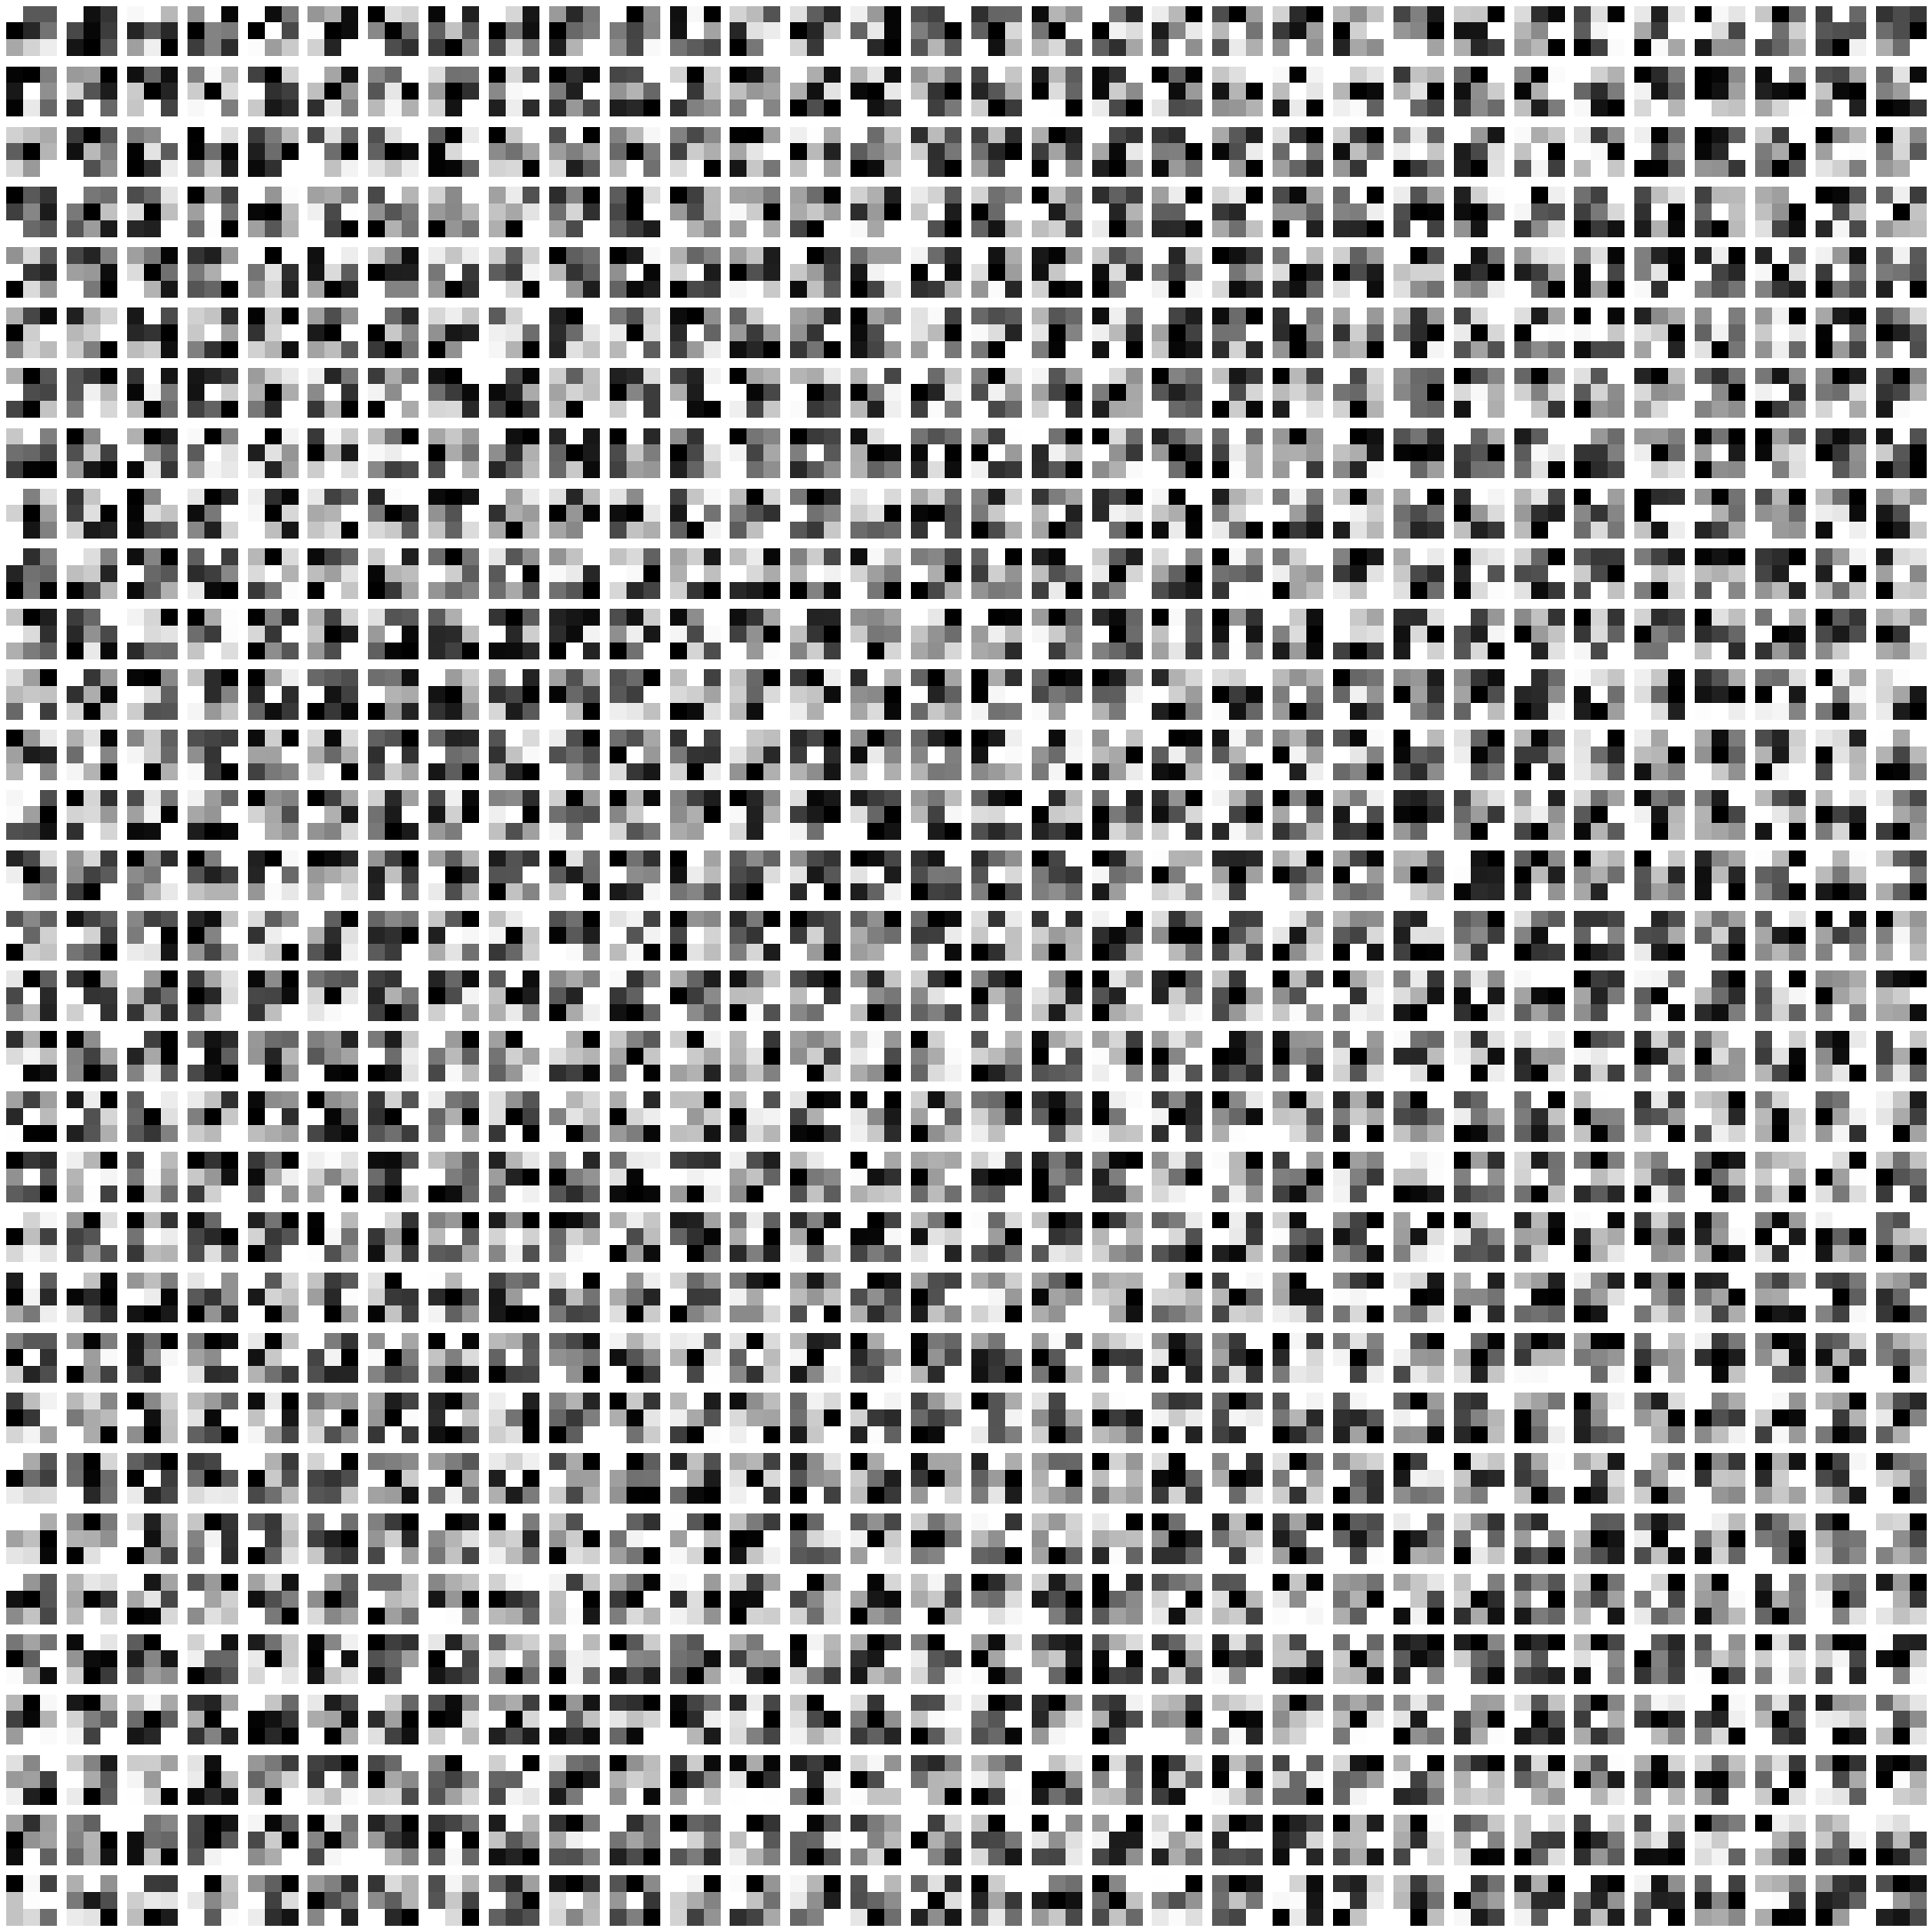

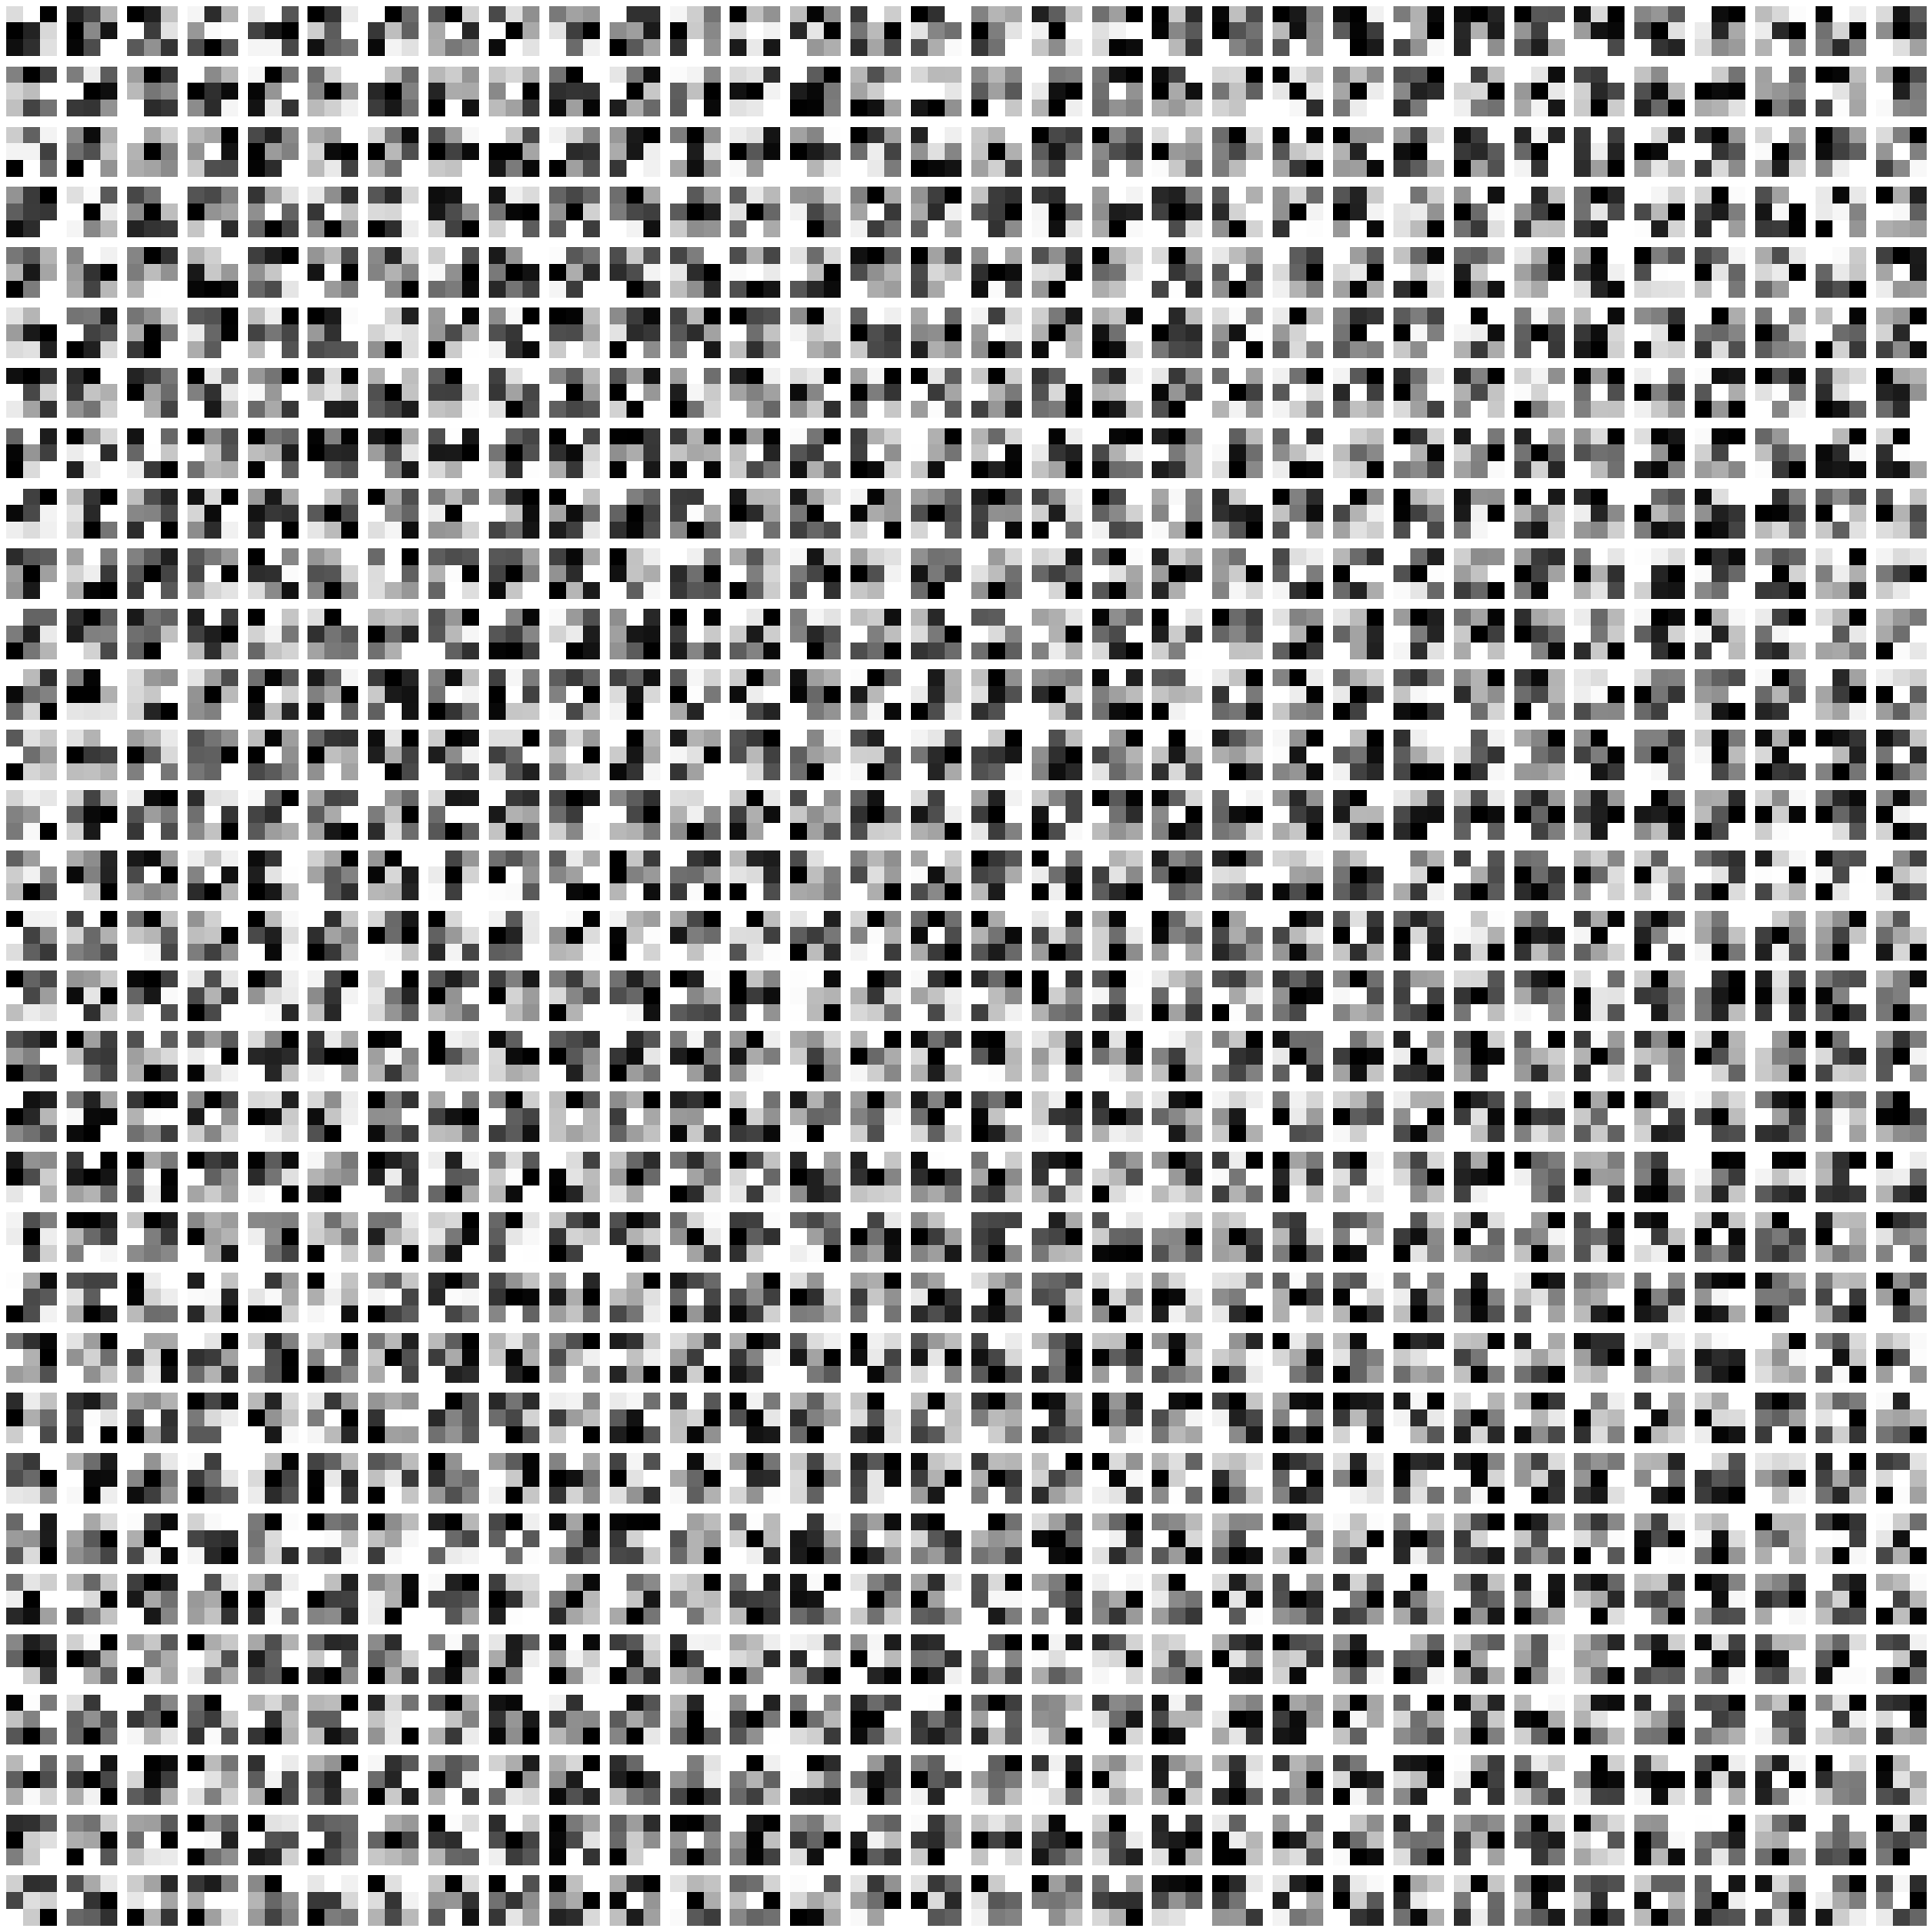

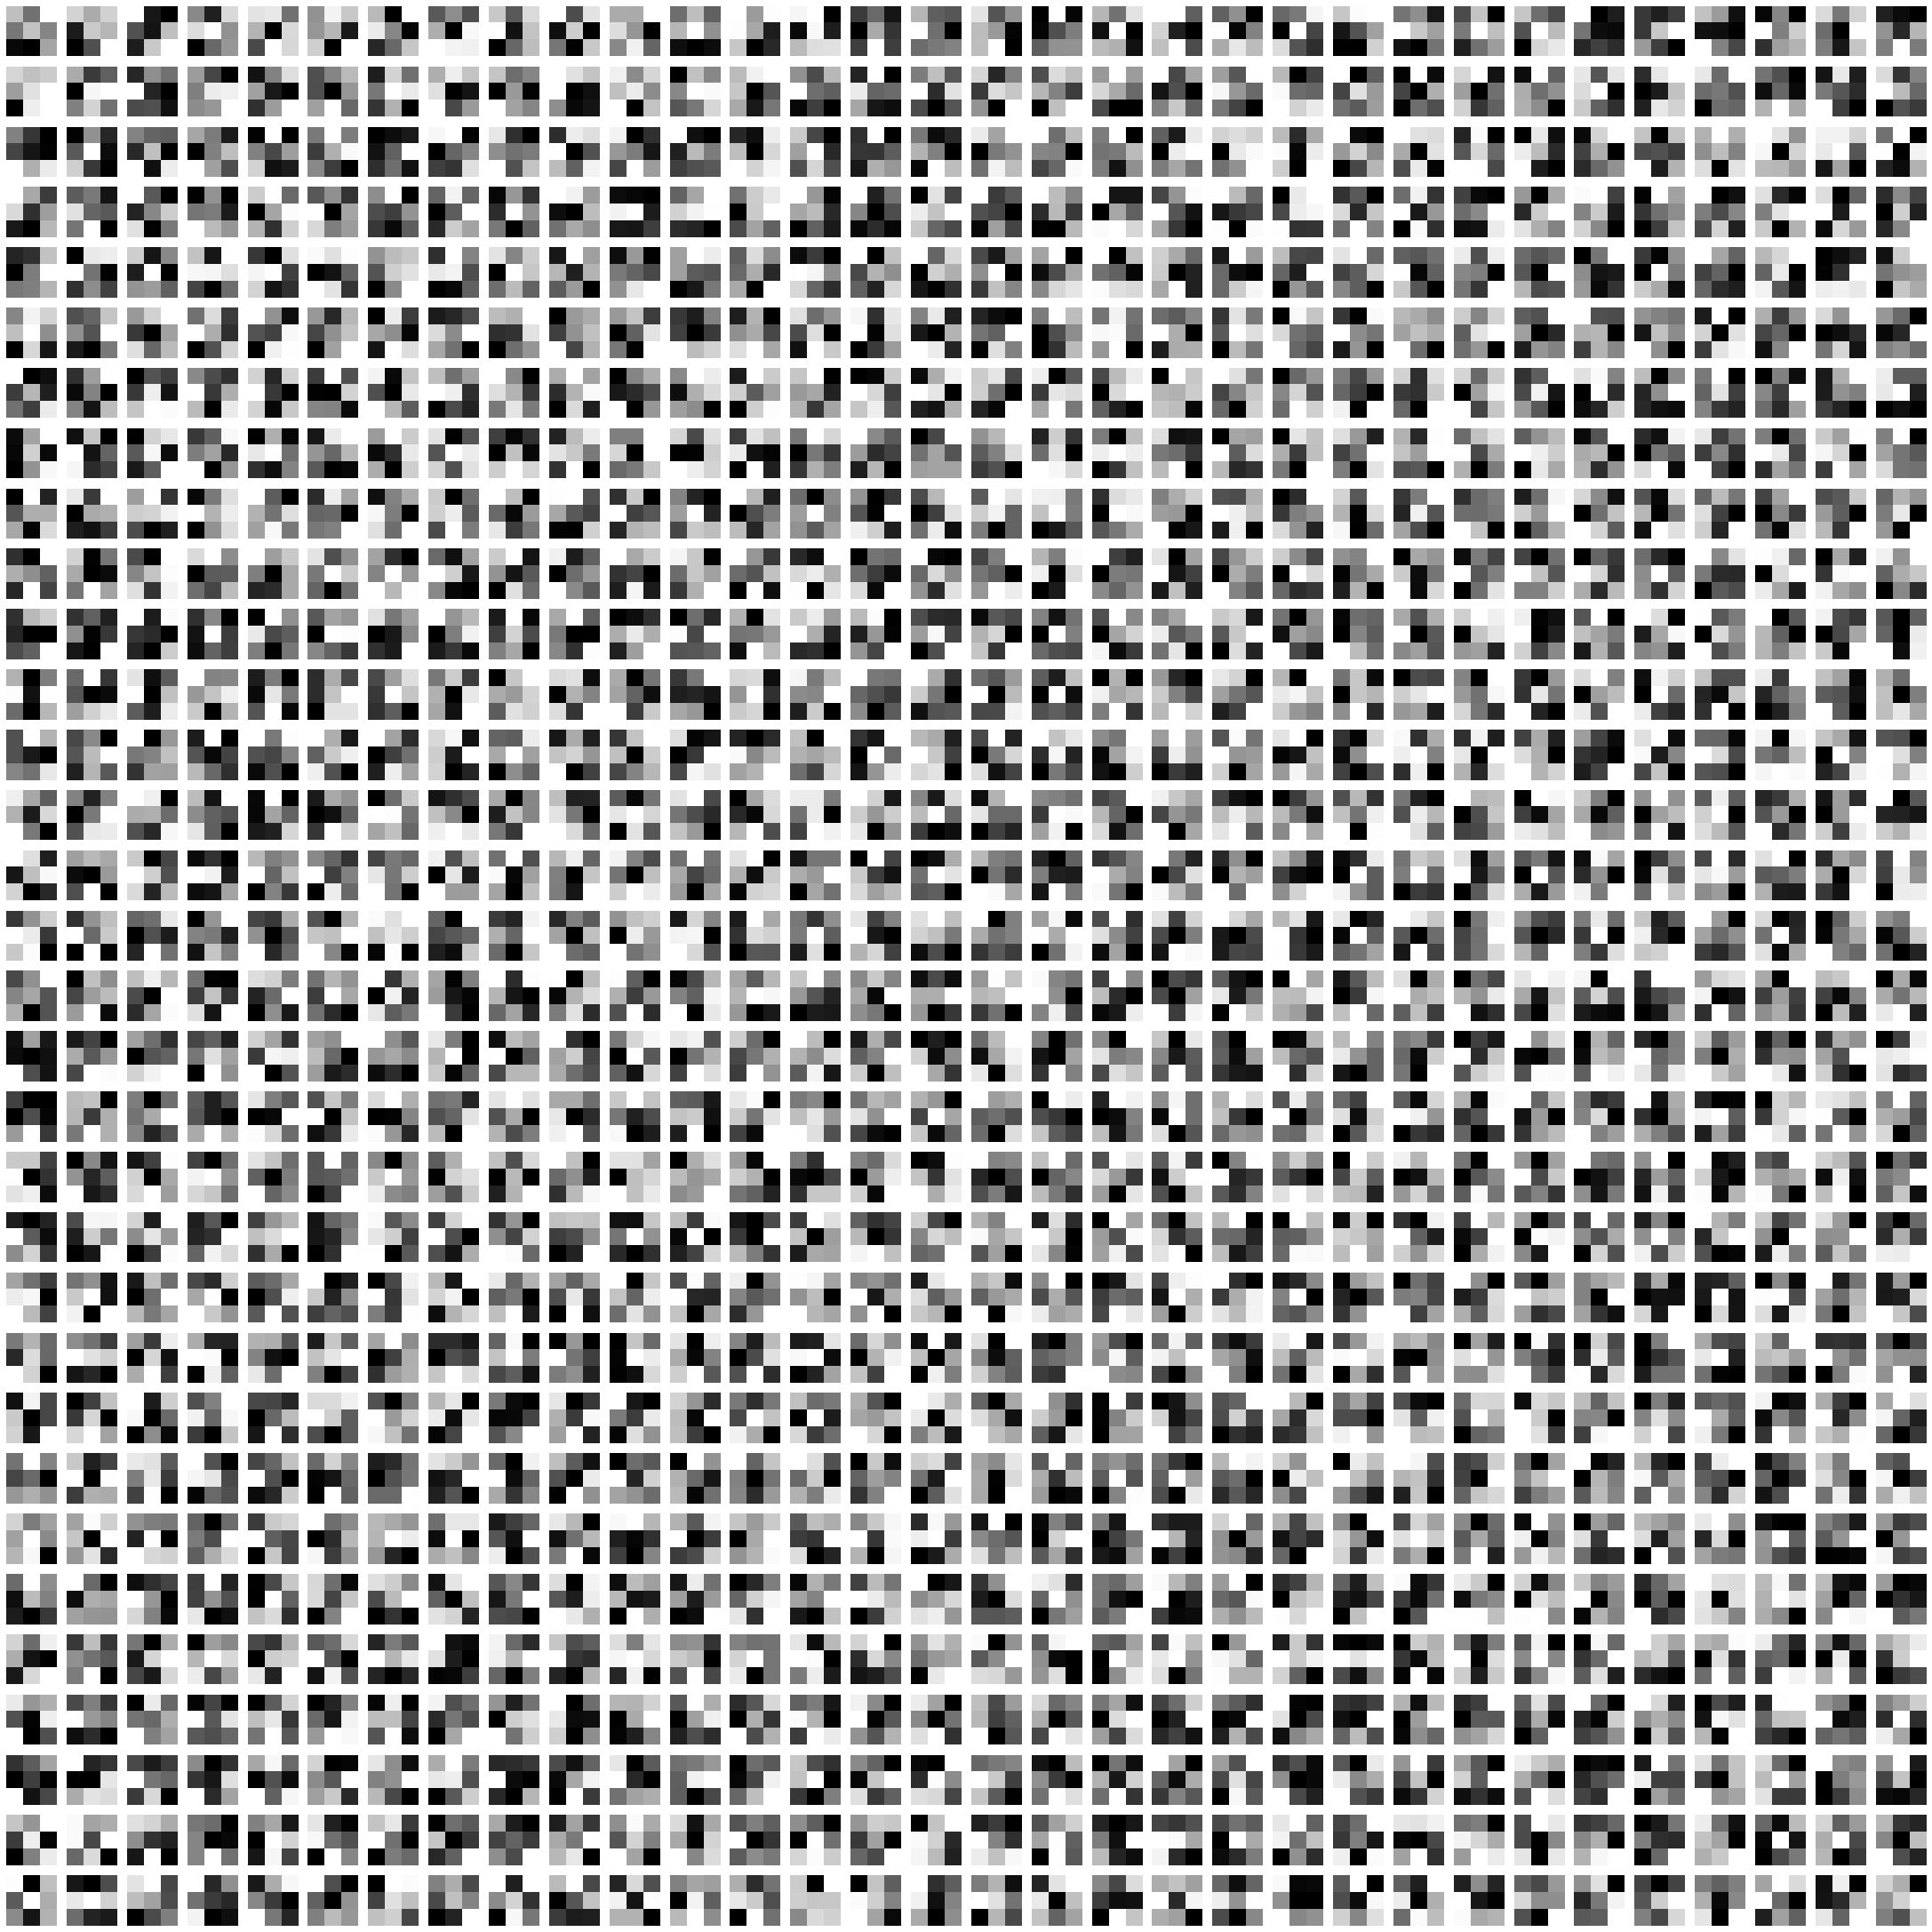

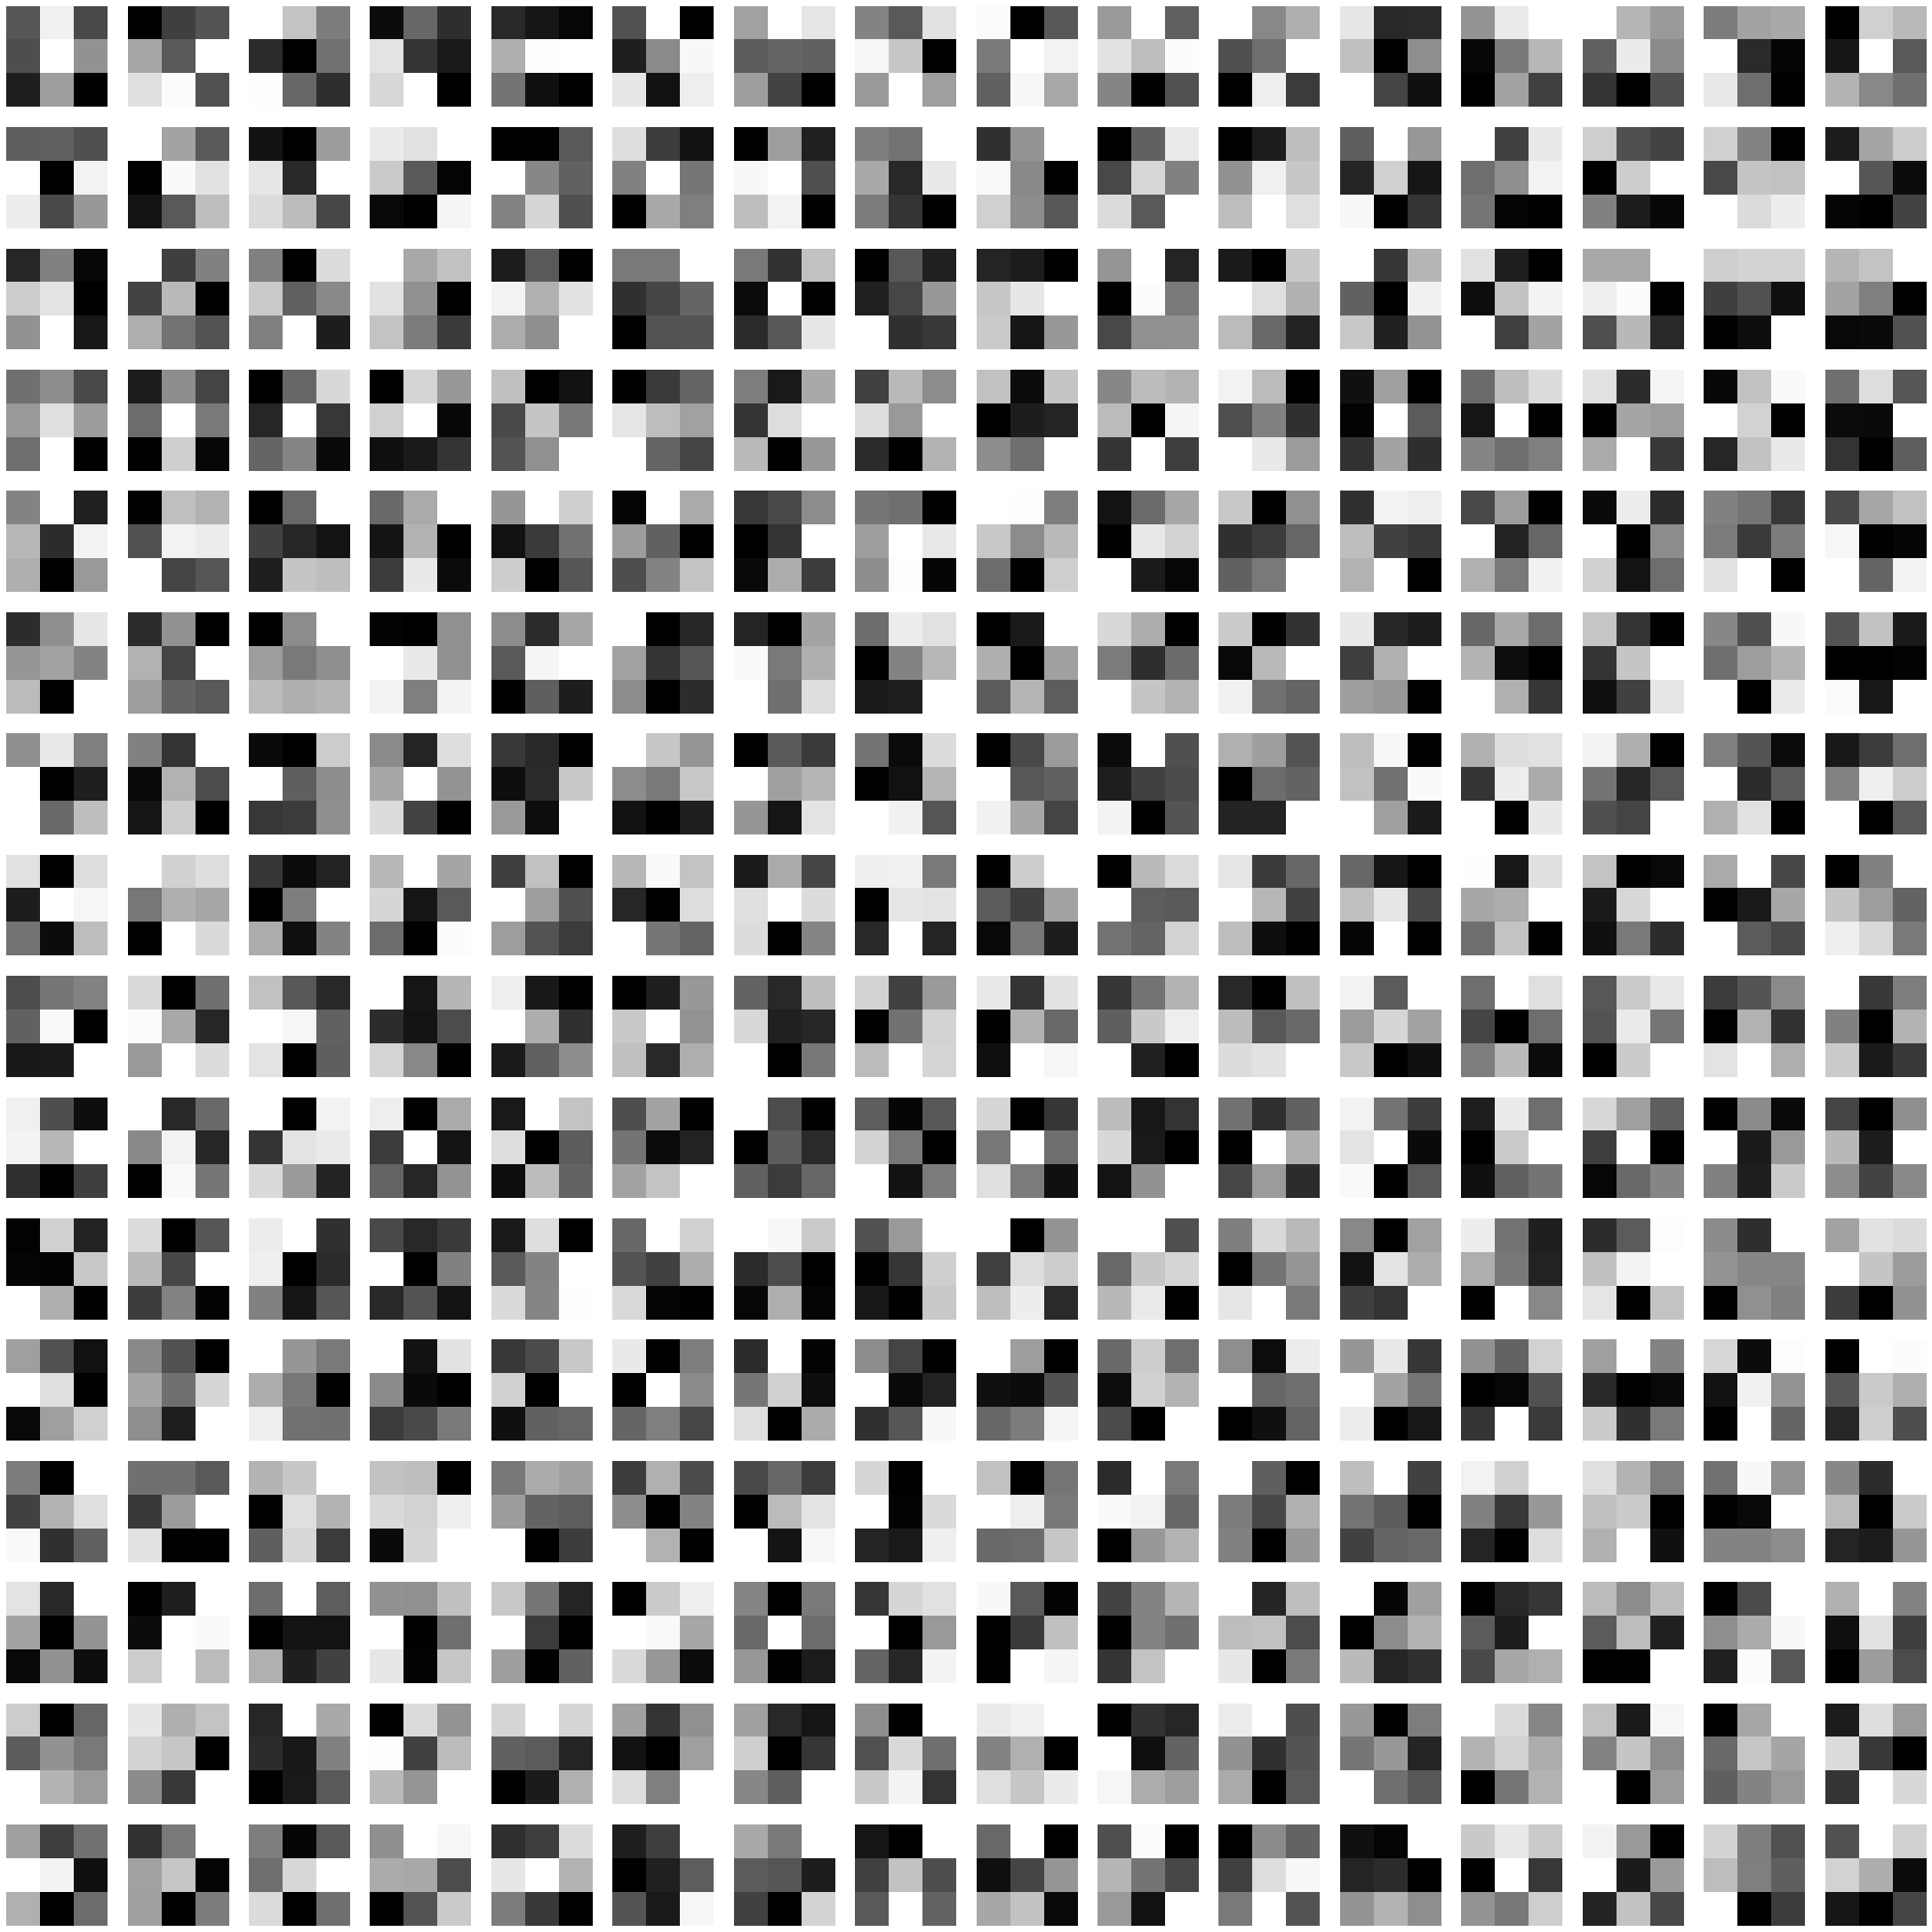

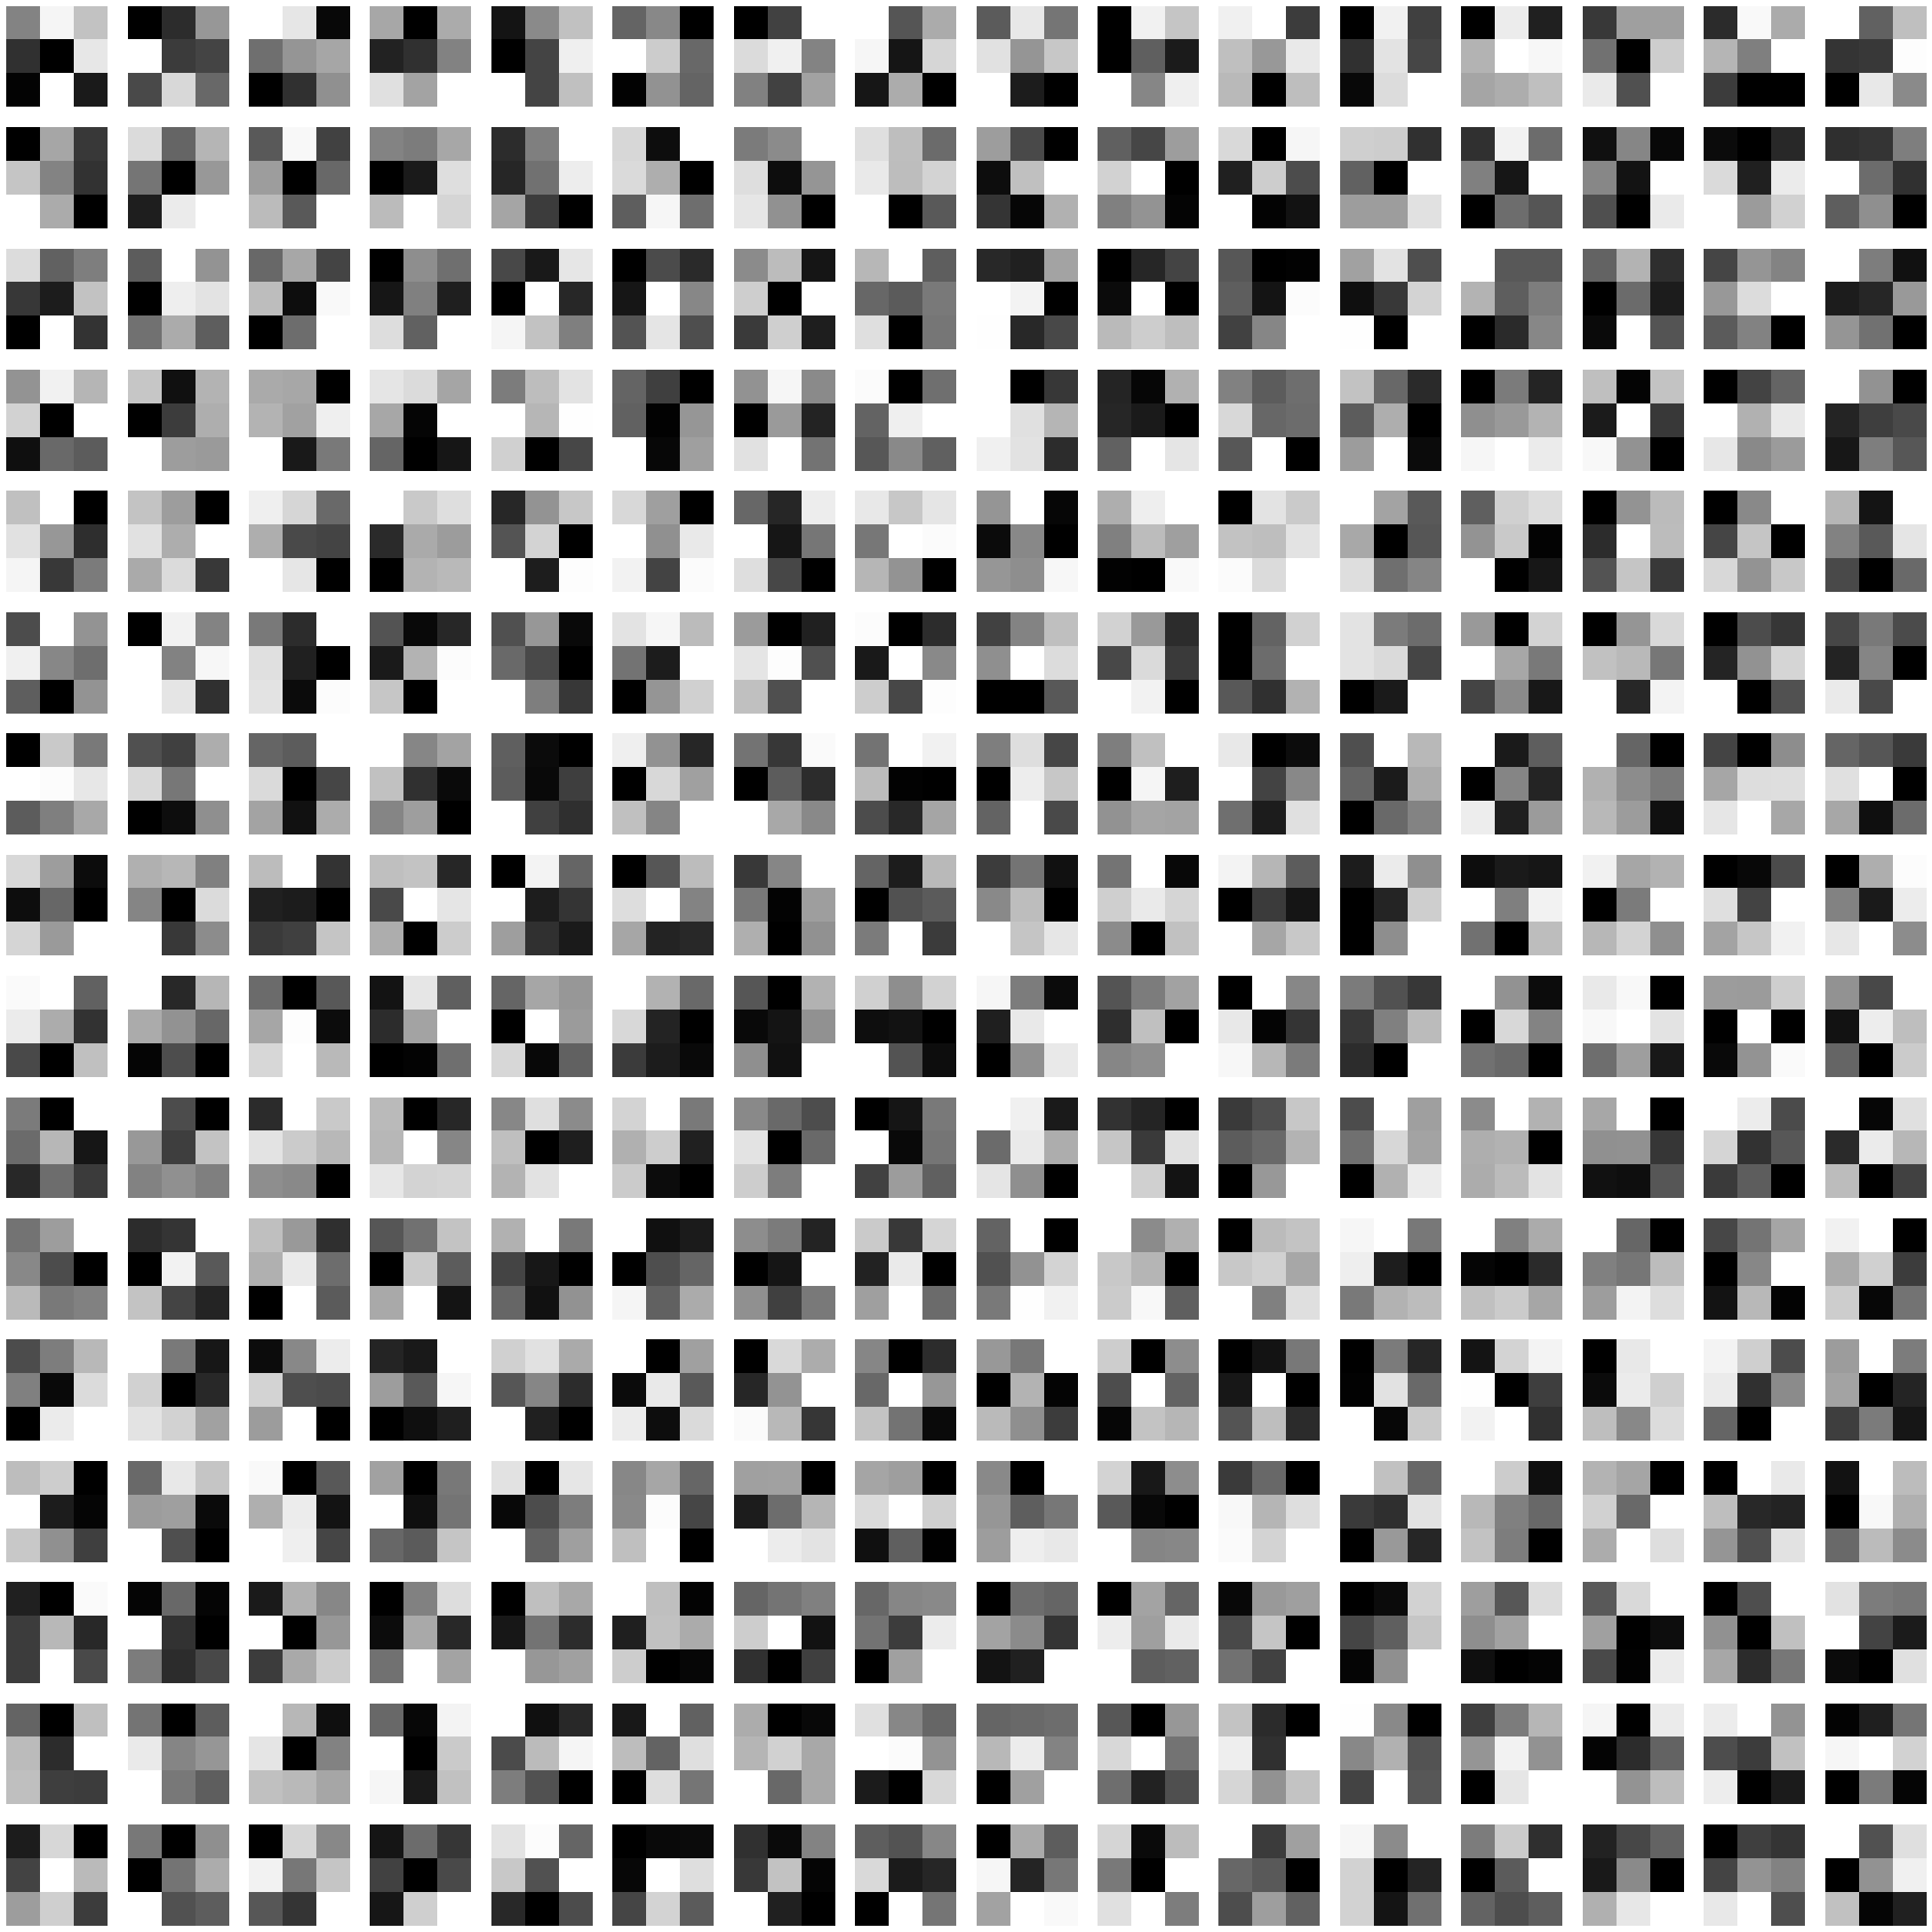

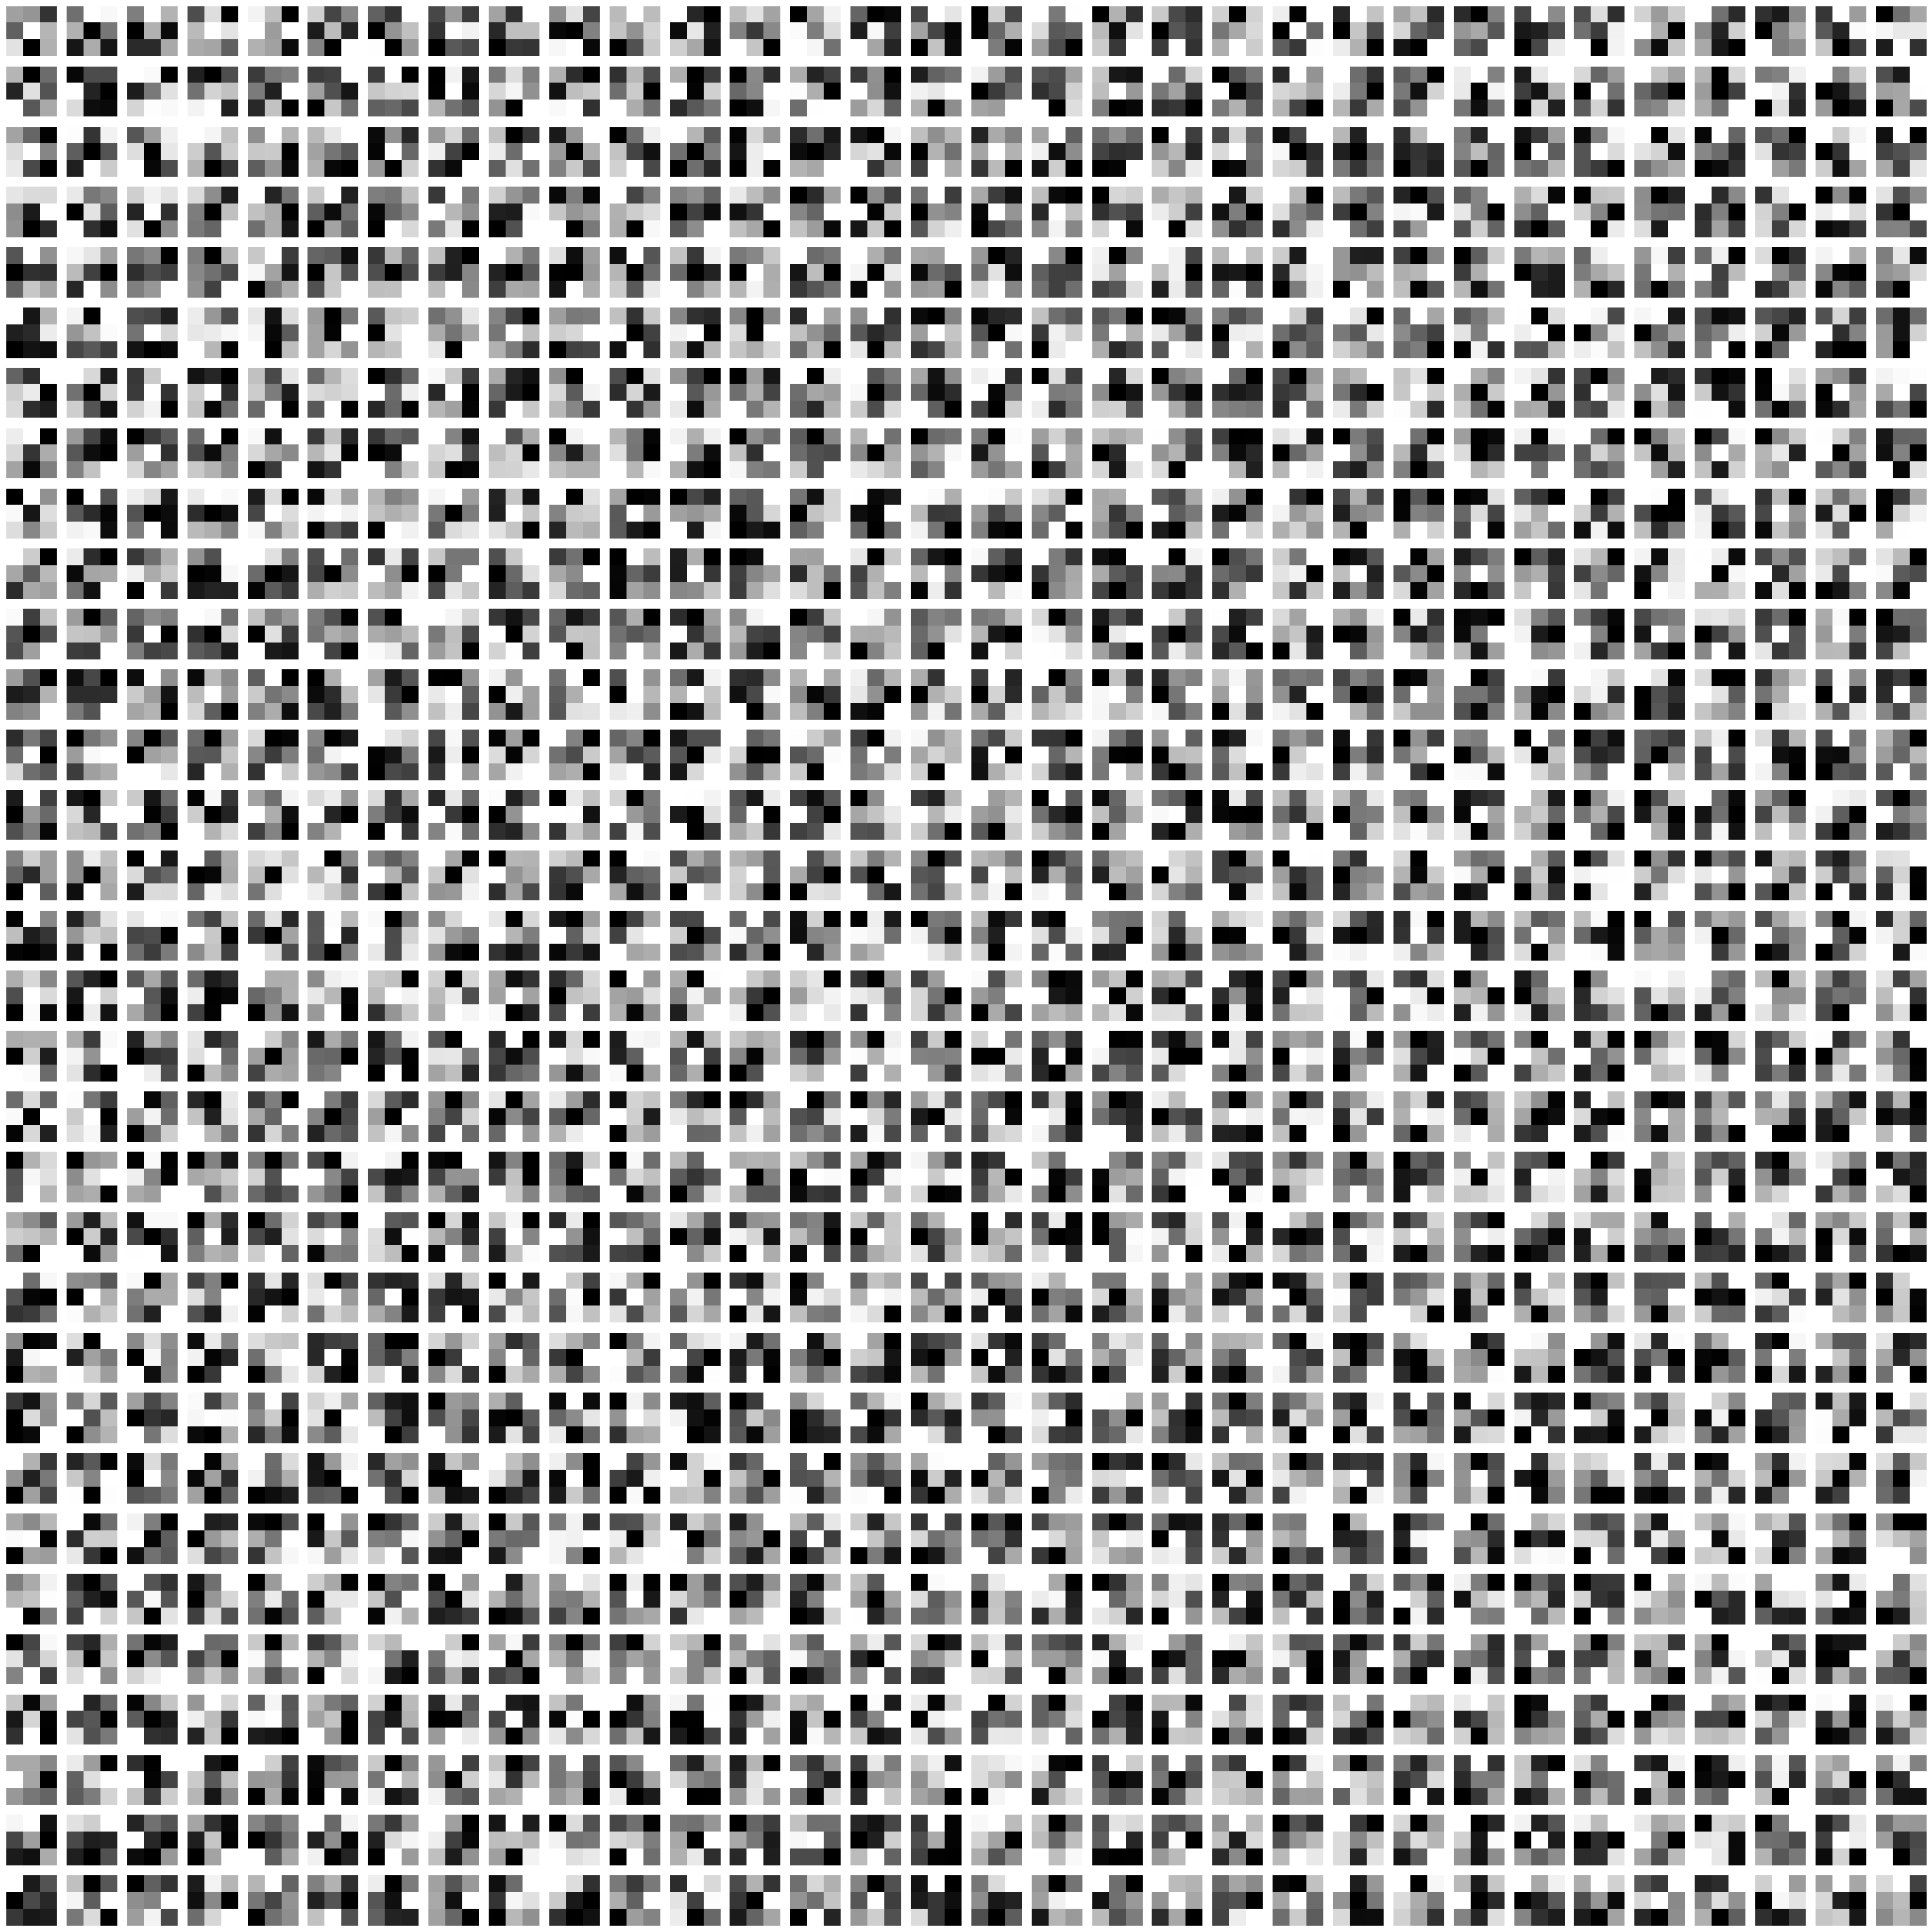

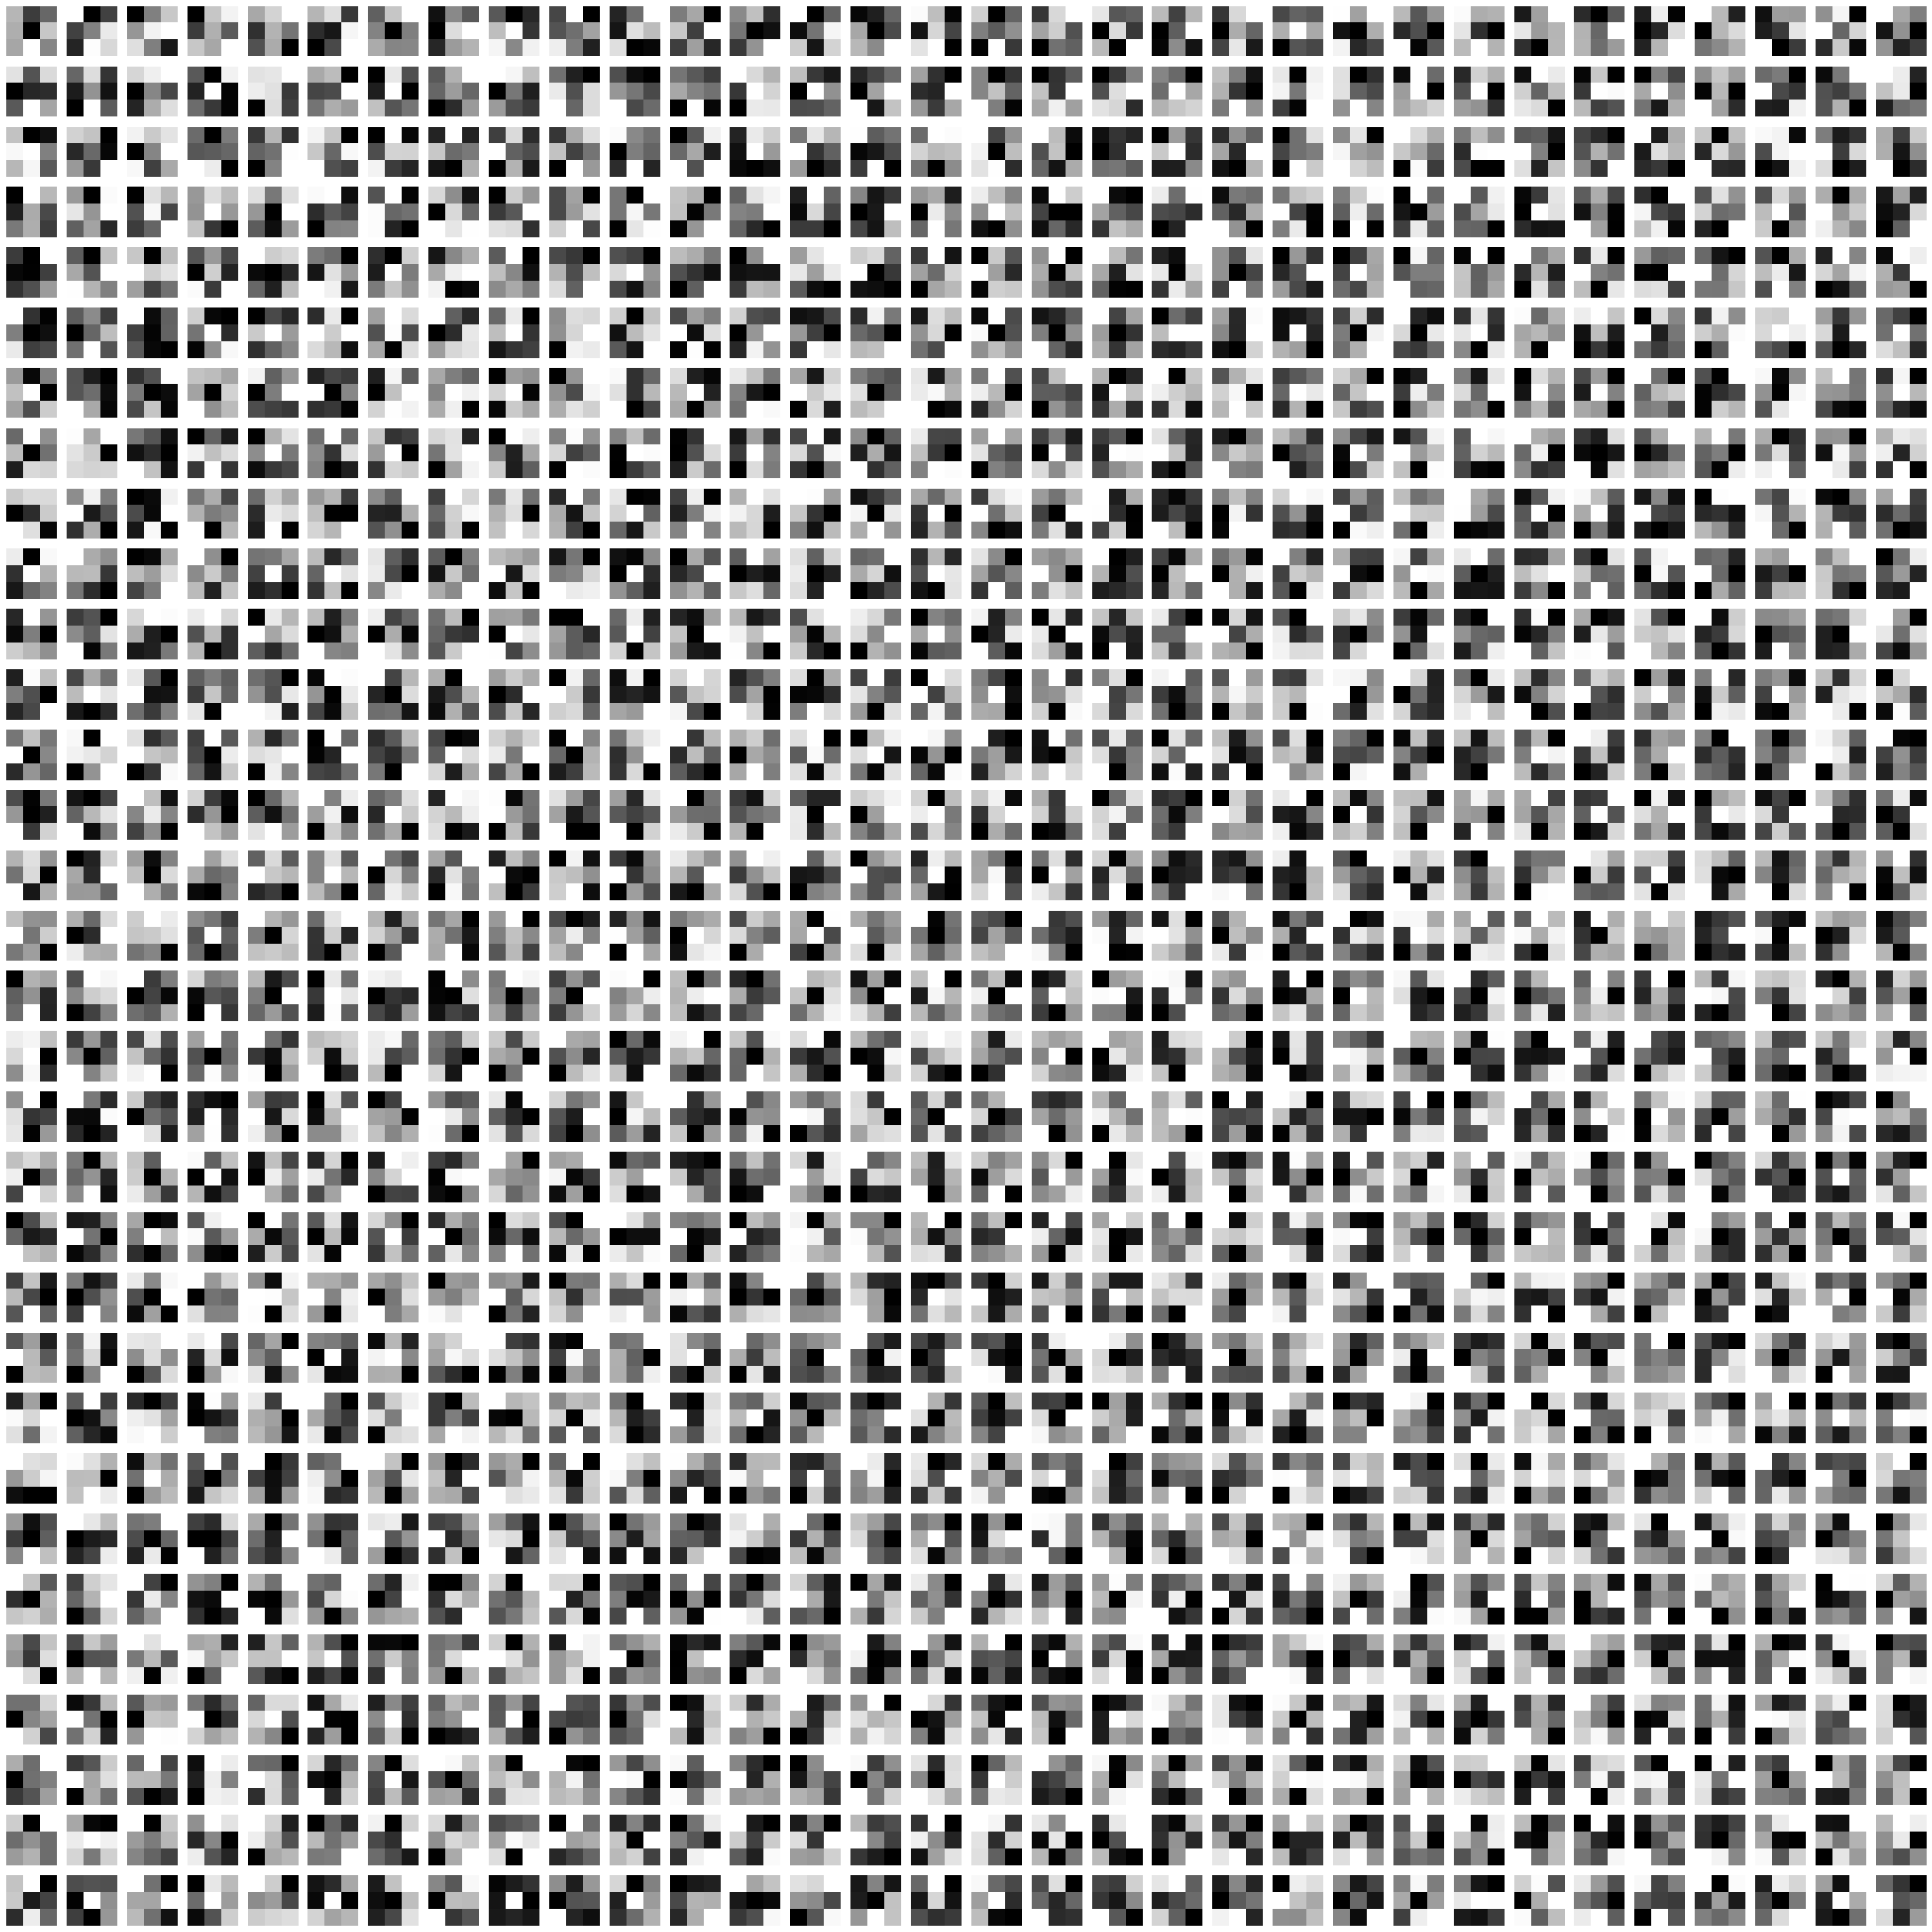

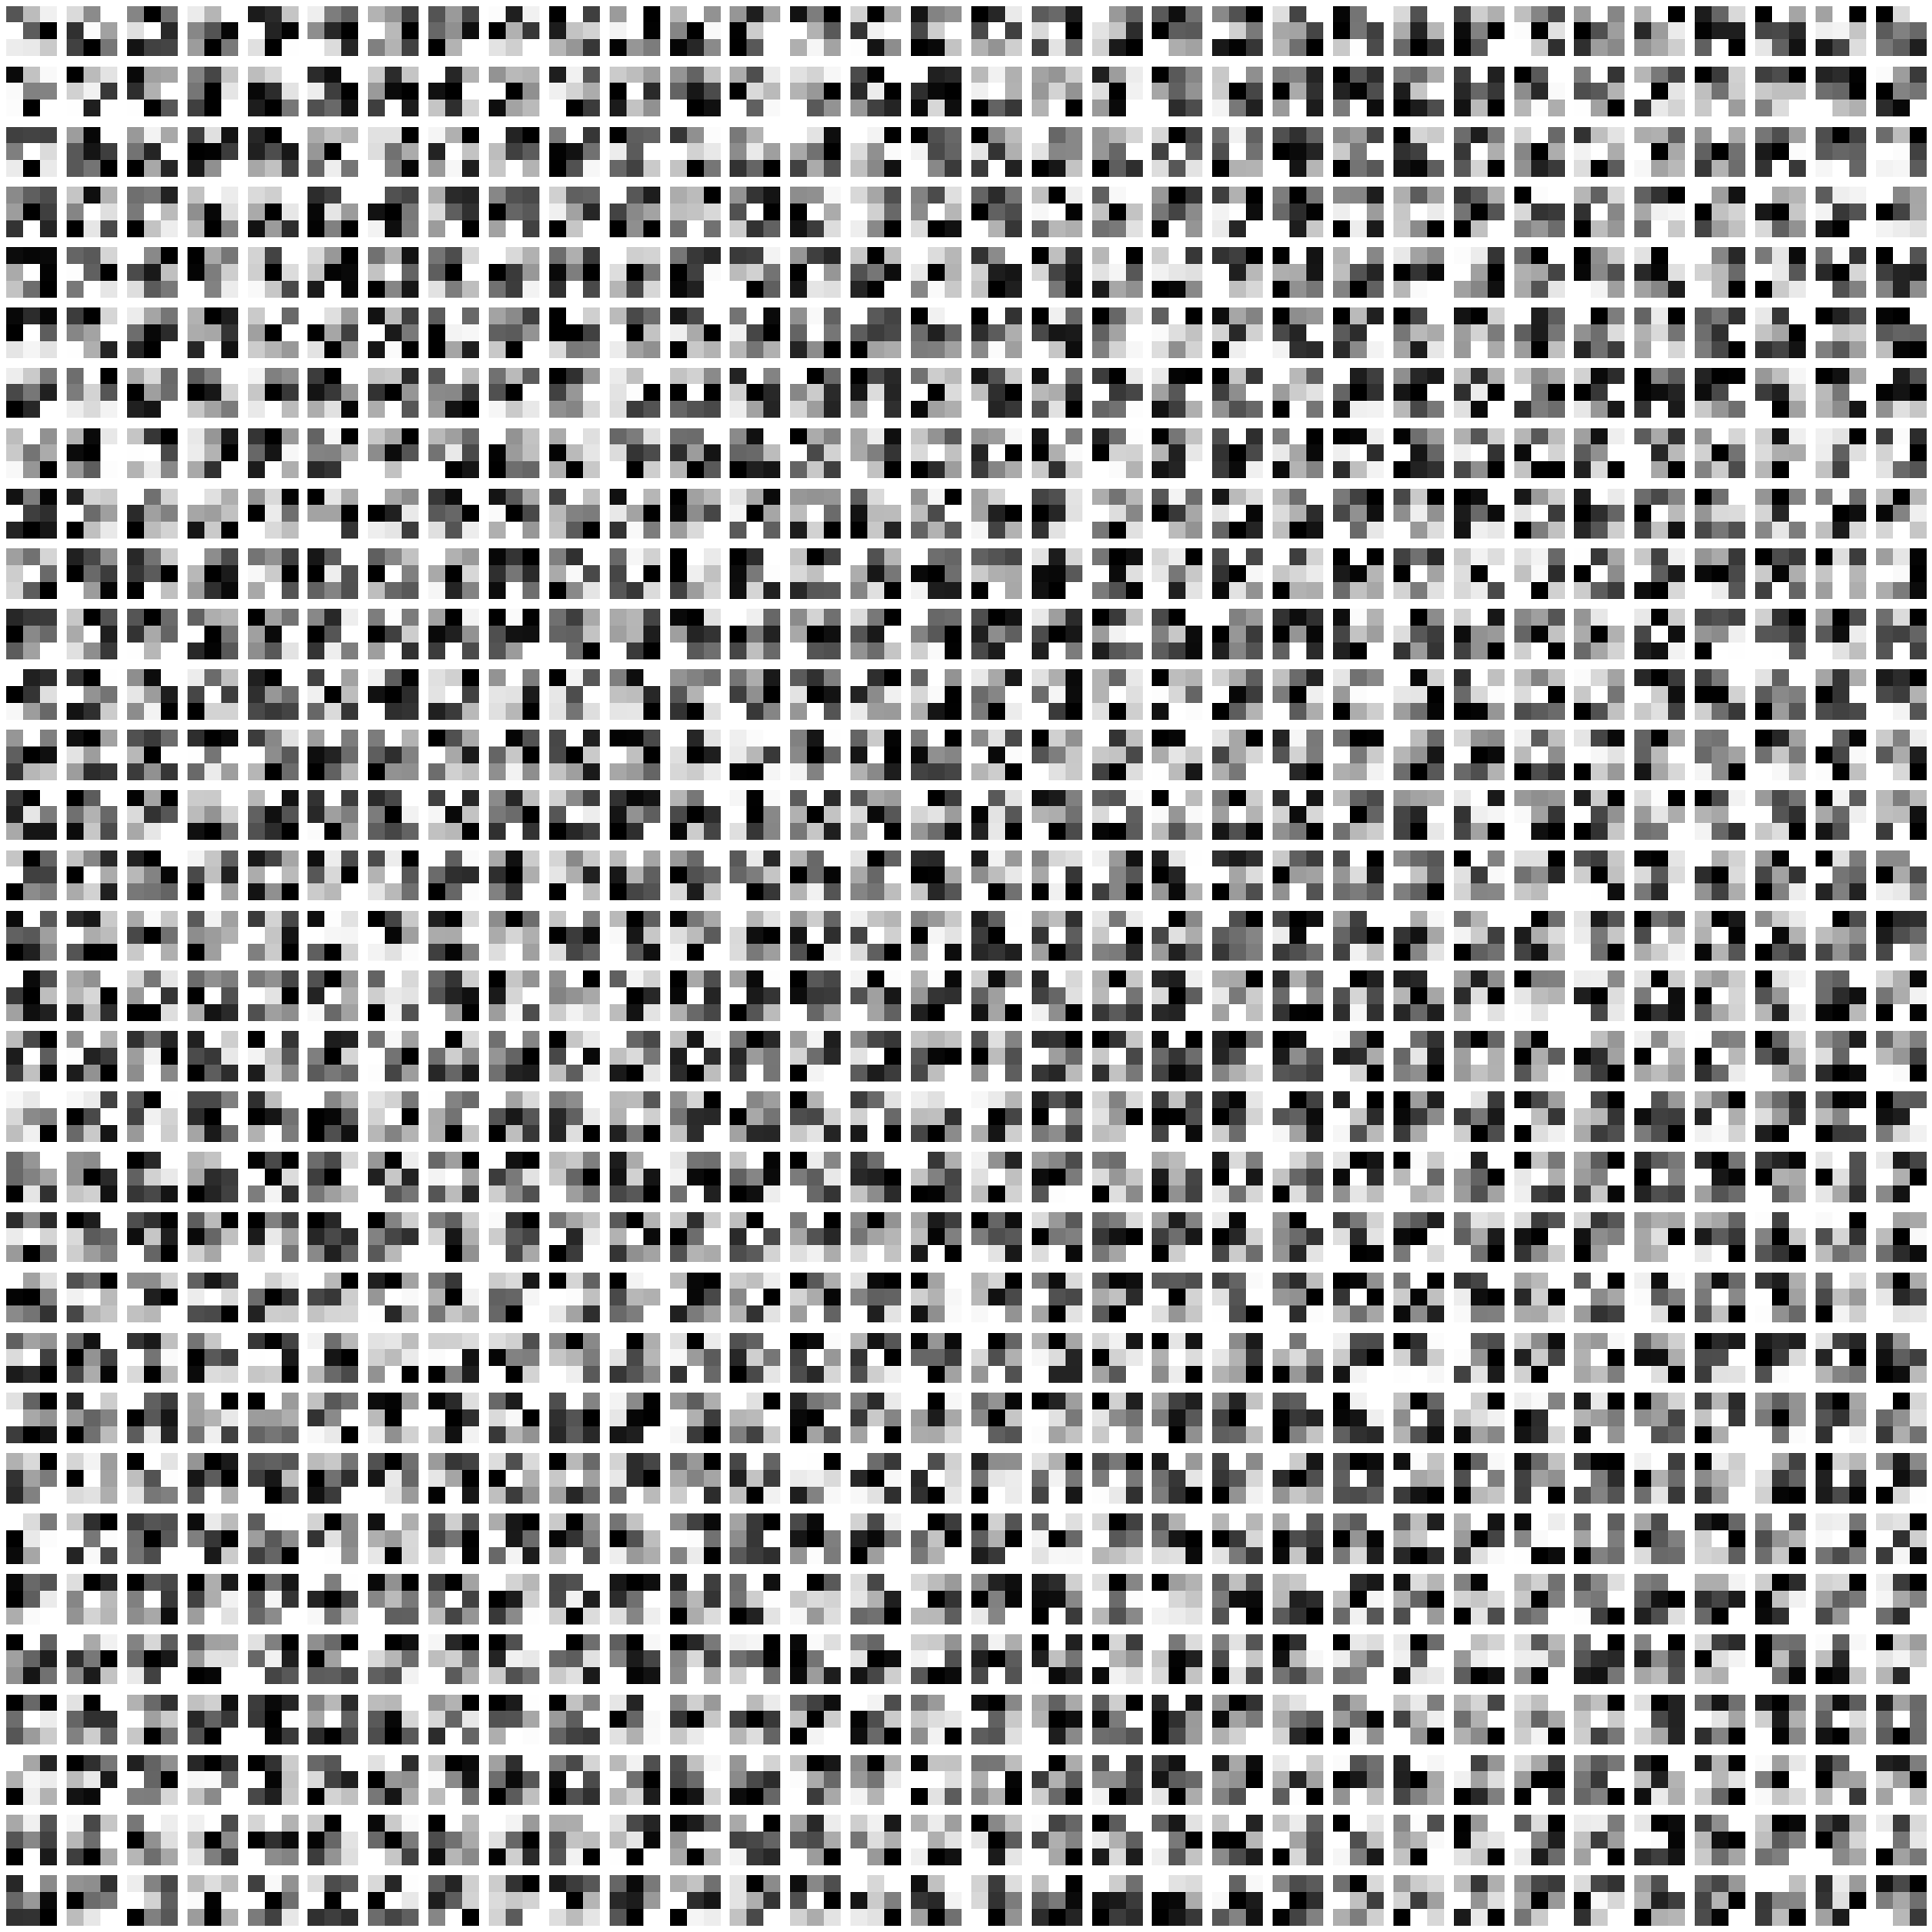

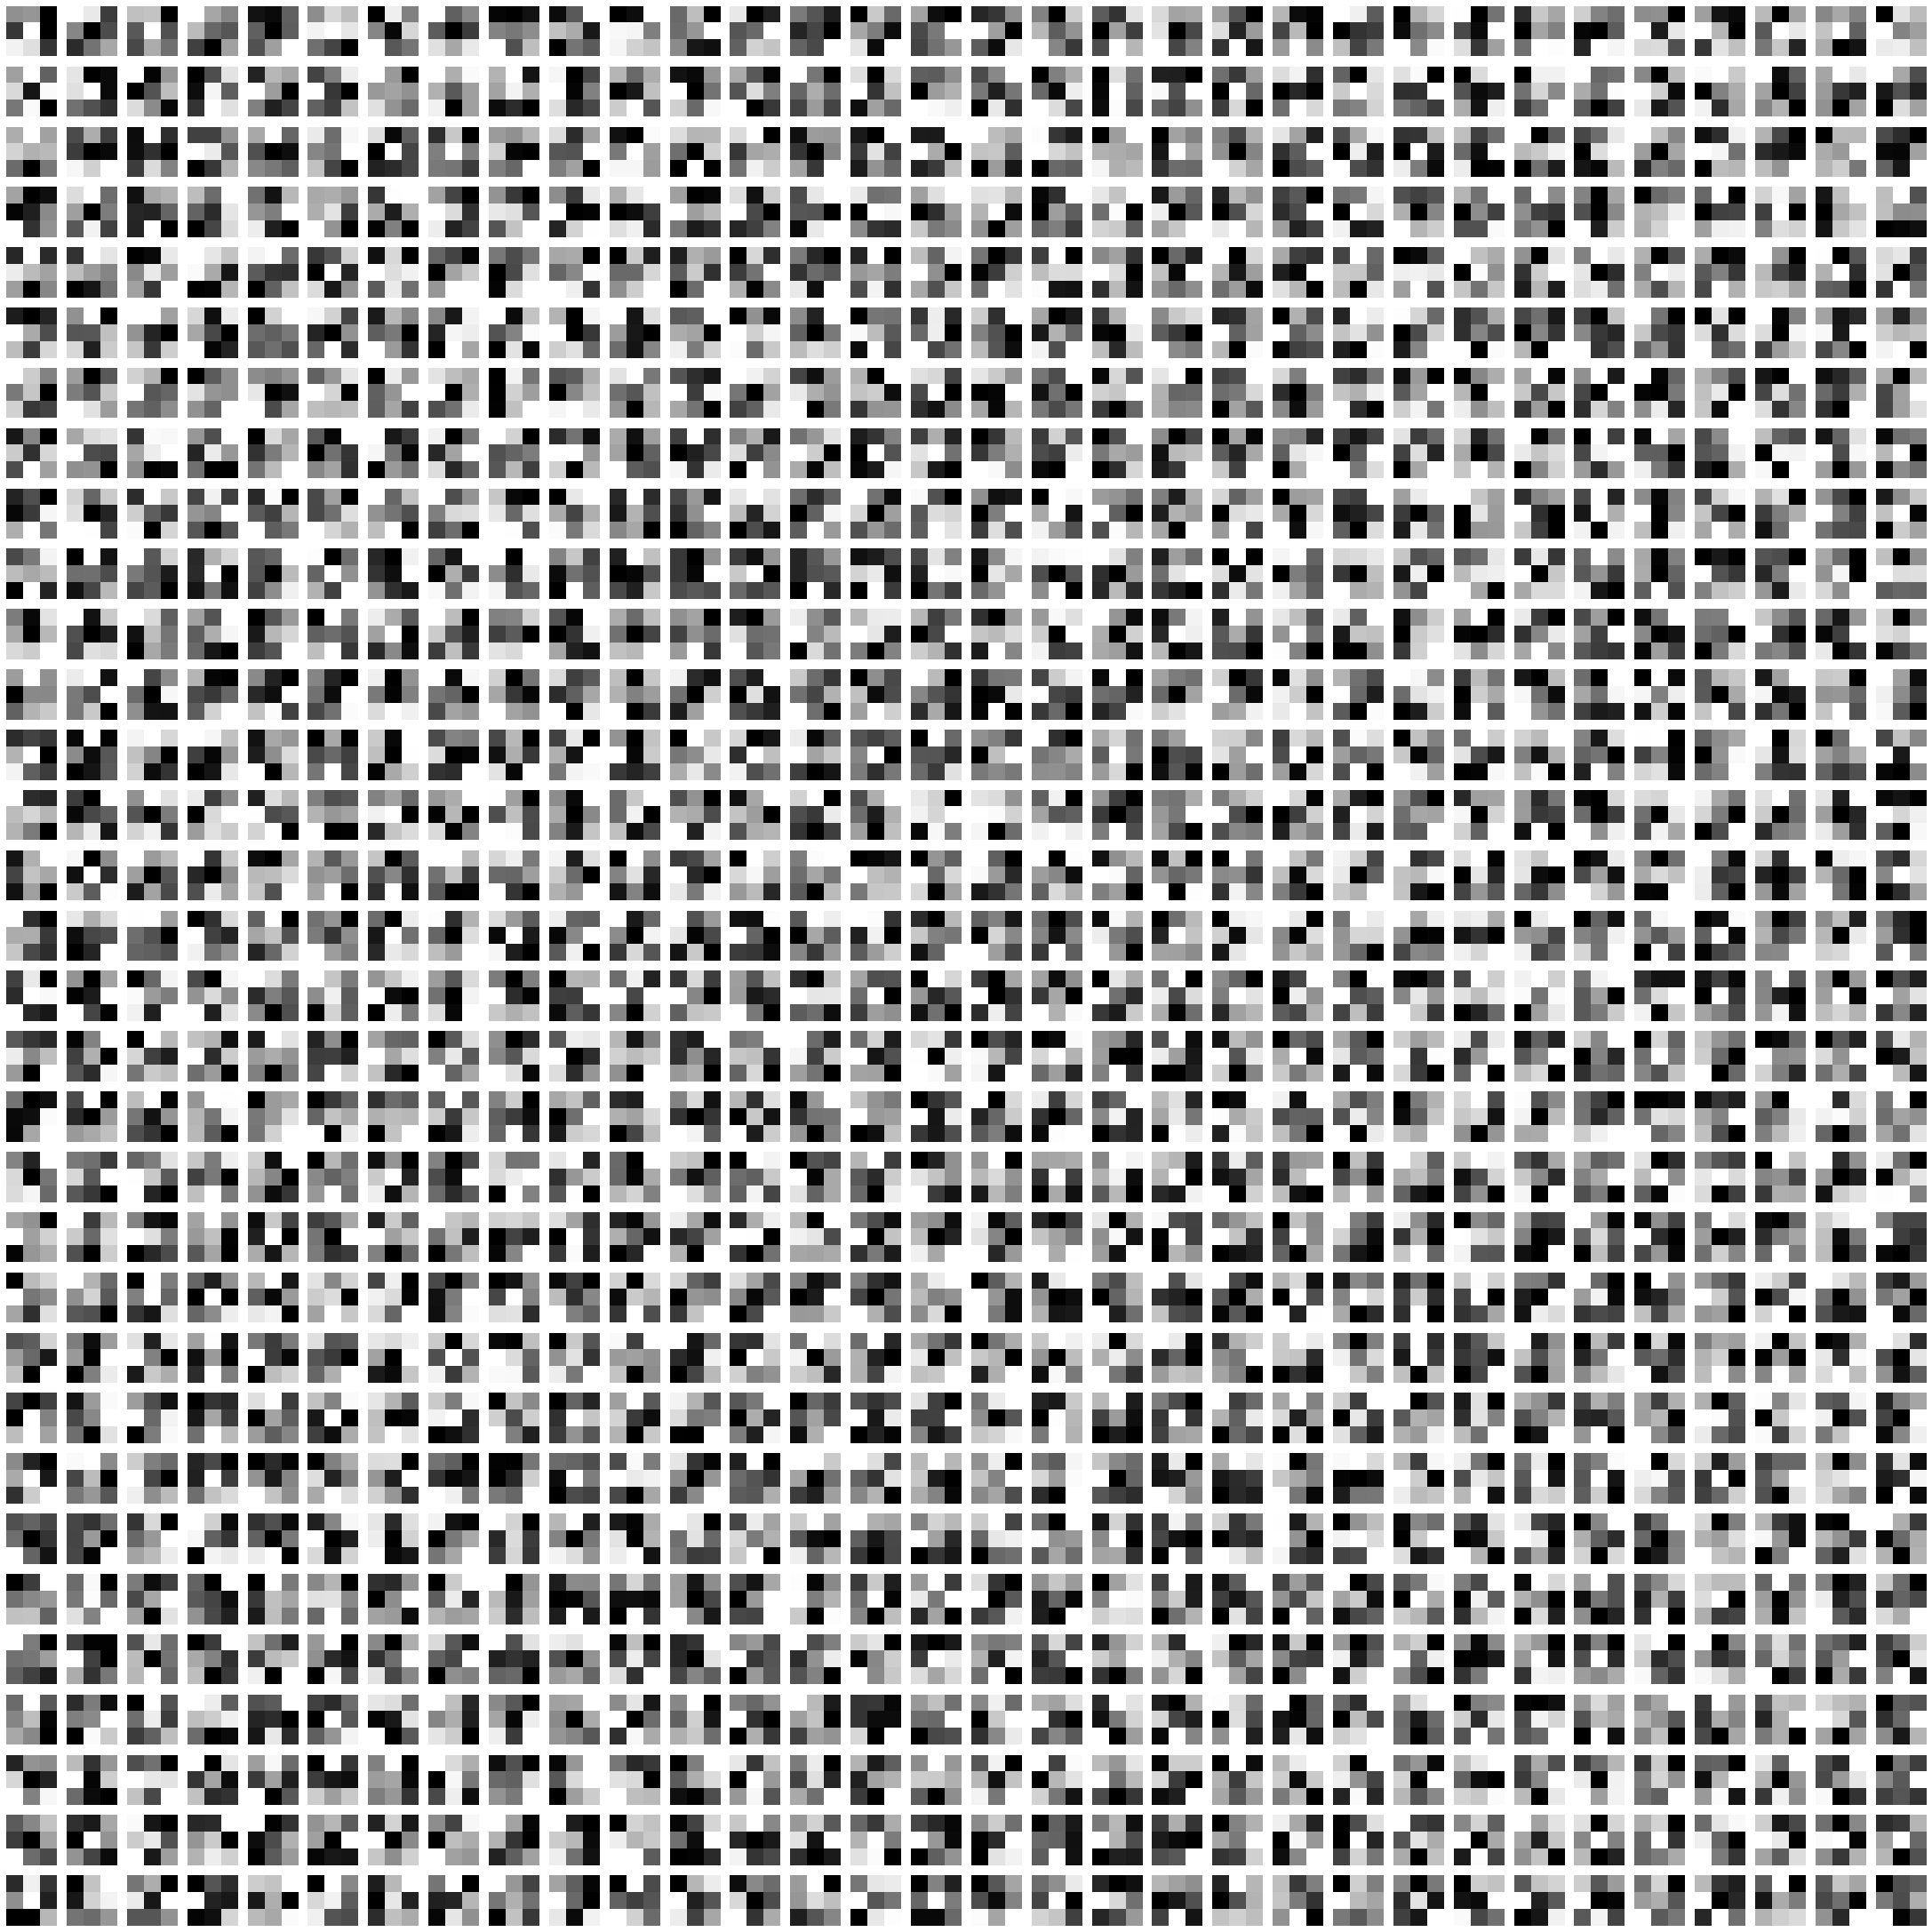

TypeError: Invalid shape () for image data

In [219]:
for layer in layers:
    kernels = layer.weight.cpu().detach().clone()
    kernels = kernels - kernels.min()
    kernels = kernels / kernels.max()
    custom_viz(kernels)

In [120]:
gym_env = create_env_det("PongNoFrameskip-v4", full_action_space=False)
gym_env.seed(0)
env = Environment(gym_env)
observation = env.initial()

for step in range(200):
    agent_outputs = model(observation, torch.tensor)
    policy_outputs, _ = agent_outputs
    observation = env.step(policy_outputs[0])

[DEBUG:55127 backend_pdf:651 2020-01-02 22:32:27,200] Assigning font /b'F1' = '/Users/andi/.conda/envs/torchbeast/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
[DEBUG:55127 backend_pdf:701 2020-01-02 22:32:27,233] Embedding font /Users/andi/.conda/envs/torchbeast/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
[DEBUG:55127 backend_pdf:708 2020-01-02 22:32:27,234] Writing TrueType font.


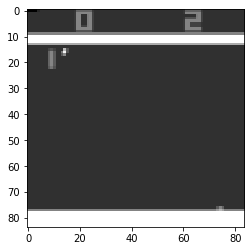

[DEBUG:55127 backend_pdf:651 2020-01-02 22:32:27,473] Assigning font /b'F1' = '/Users/andi/.conda/envs/torchbeast/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
[DEBUG:55127 backend_pdf:701 2020-01-02 22:32:27,508] Embedding font /Users/andi/.conda/envs/torchbeast/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
[DEBUG:55127 backend_pdf:708 2020-01-02 22:32:27,509] Writing TrueType font.


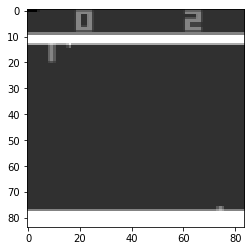

[DEBUG:55127 backend_pdf:651 2020-01-02 22:32:27,816] Assigning font /b'F1' = '/Users/andi/.conda/envs/torchbeast/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
[DEBUG:55127 backend_pdf:701 2020-01-02 22:32:27,850] Embedding font /Users/andi/.conda/envs/torchbeast/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
[DEBUG:55127 backend_pdf:708 2020-01-02 22:32:27,851] Writing TrueType font.


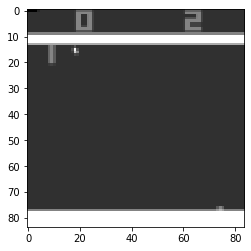

[DEBUG:55127 backend_pdf:651 2020-01-02 22:32:28,054] Assigning font /b'F1' = '/Users/andi/.conda/envs/torchbeast/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf'
[DEBUG:55127 backend_pdf:701 2020-01-02 22:32:28,087] Embedding font /Users/andi/.conda/envs/torchbeast/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf.
[DEBUG:55127 backend_pdf:708 2020-01-02 22:32:28,088] Writing TrueType font.


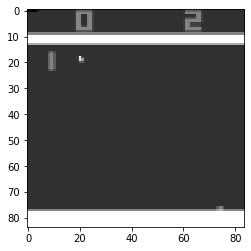

In [243]:
for i in range(4):
    plt.imshow(observation["frame"].numpy()[0,0,i,:,:], cmap='gray')
    plt.savefig(str(i) + ".pdf")
    plt.show()

In [222]:
get_all_layers(model)
visualisation = {}
print(model(observation, torch.tensor))
v = list(visualisation.values())

((tensor([[[5]]]), tensor([[[ 0.6279,  0.5250, -1.7313,  1.1061, -1.6828,  1.3525]]],
       grad_fn=<ViewBackward>), tensor([[[0.3749]]]), tensor([[[0.3749]]], grad_fn=<ViewBackward>)), <built-in method tensor of type object at 0x1214fae90>)


Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


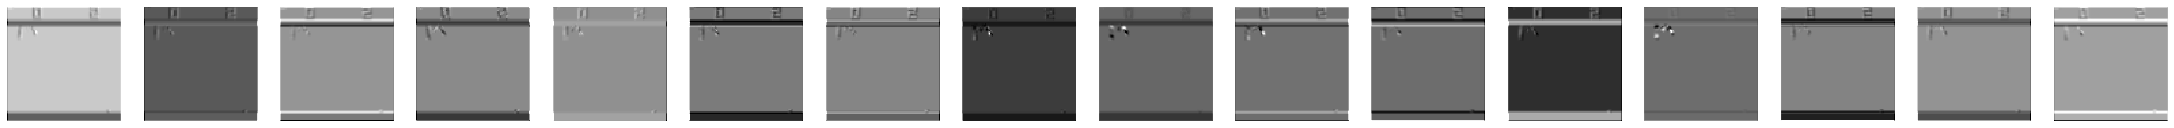

MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)


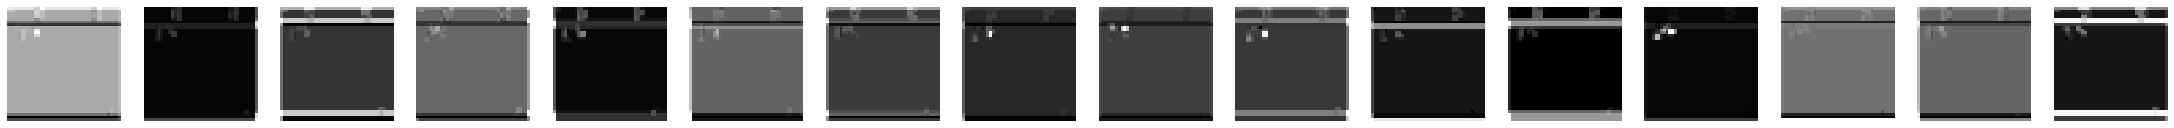

ReLU()


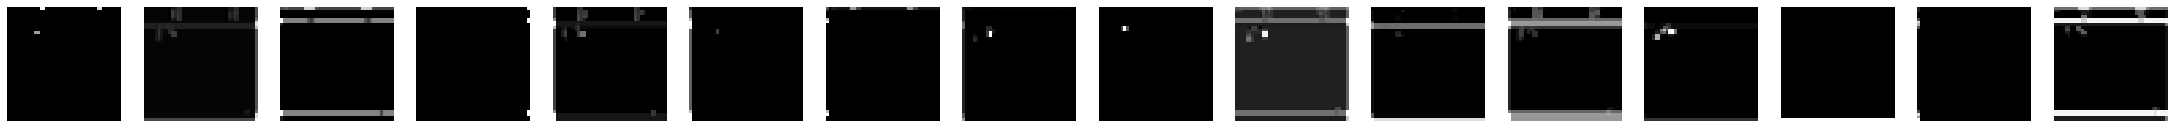

Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


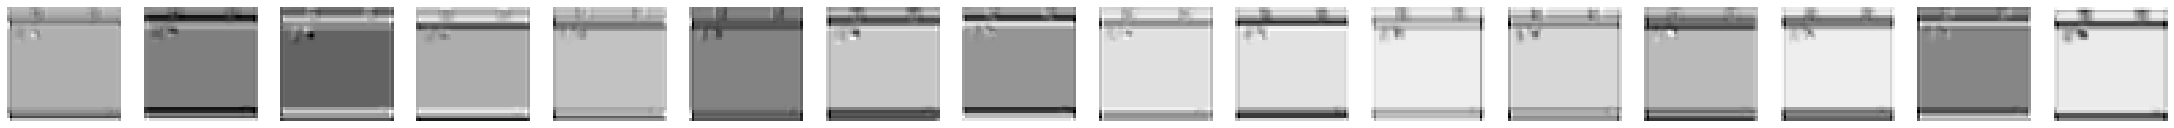

ReLU()


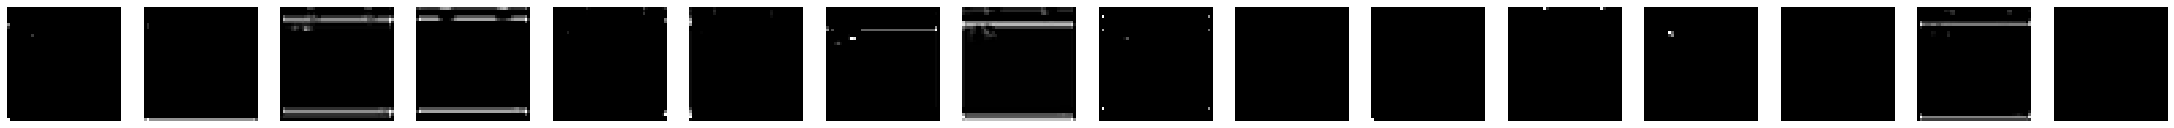

Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


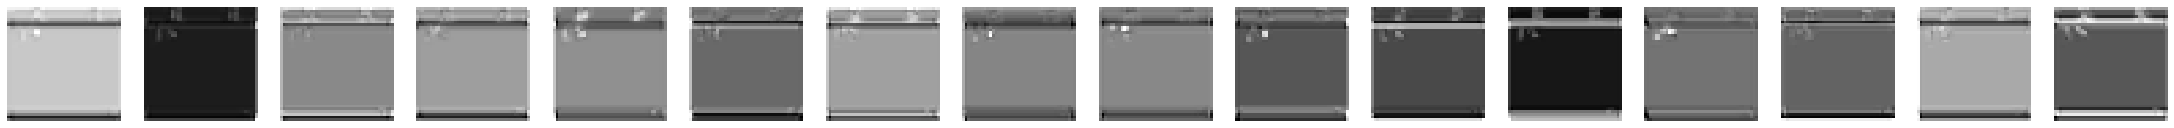

ReLU()


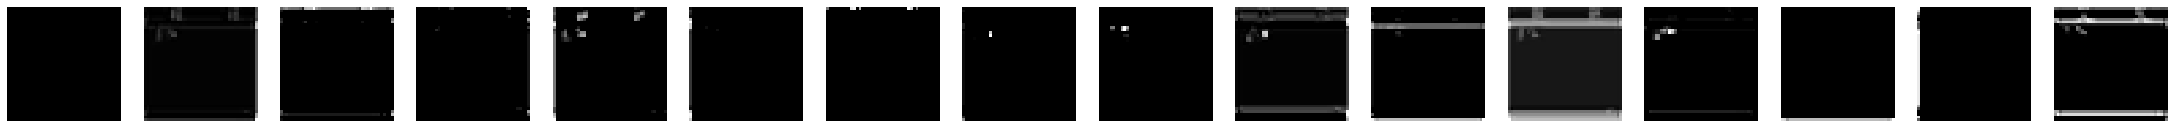

Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


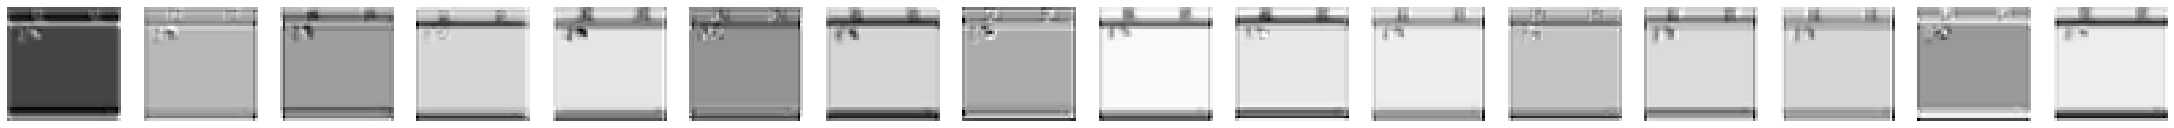

ReLU()


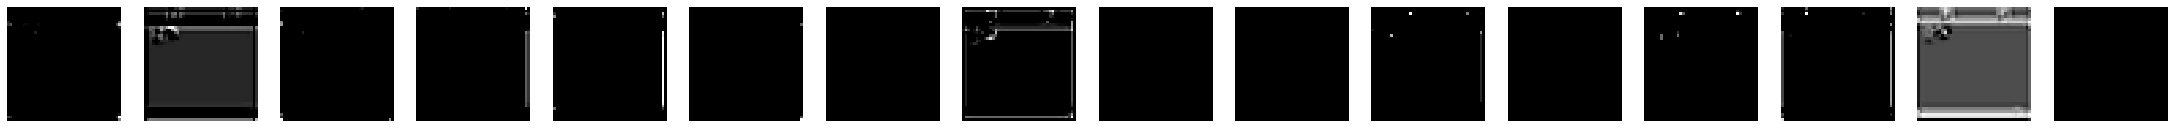

Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


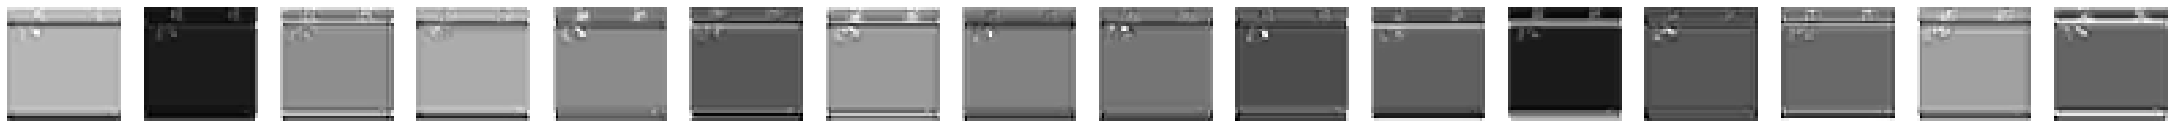

Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


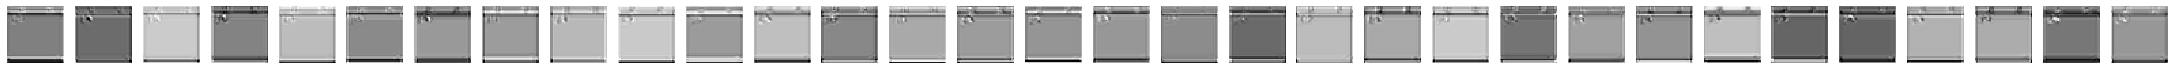

MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)


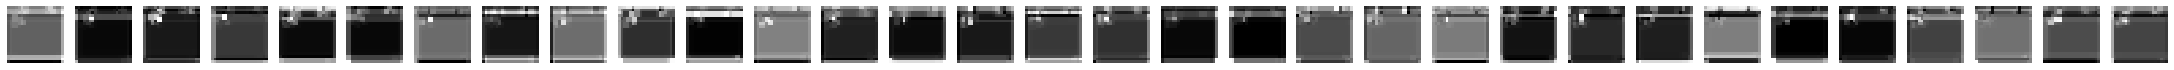

ReLU()


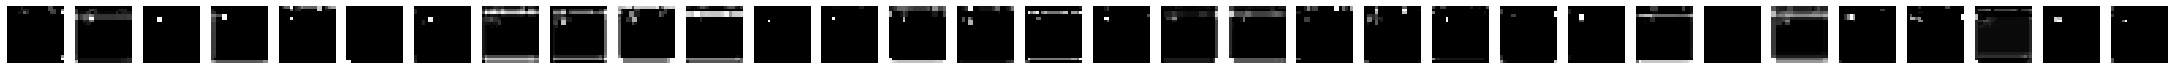

Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


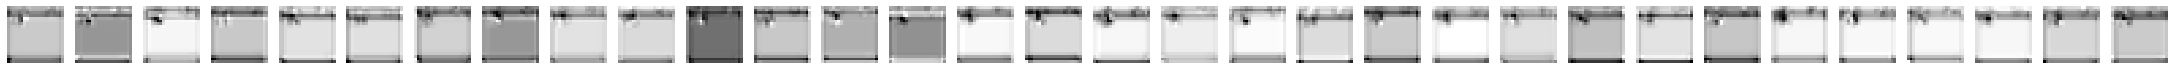

ReLU()


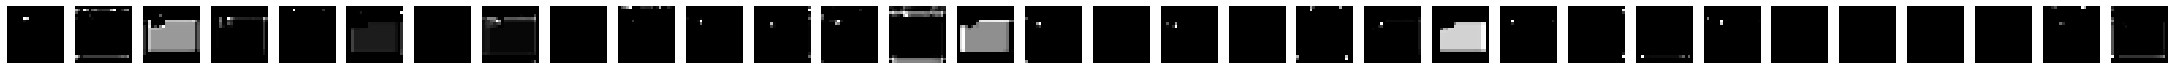

Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


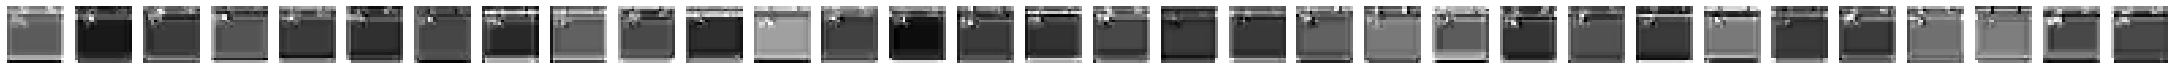

ReLU()


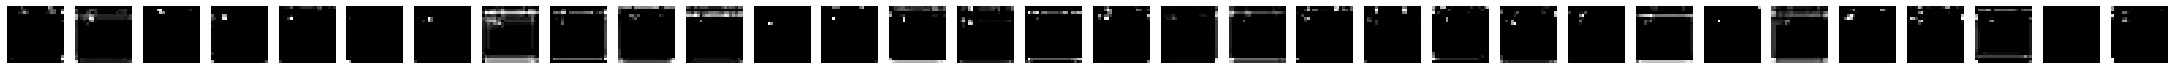

Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


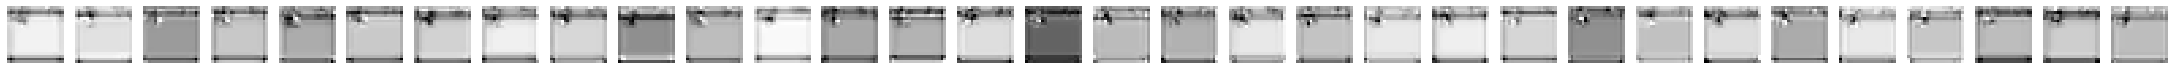

ReLU()


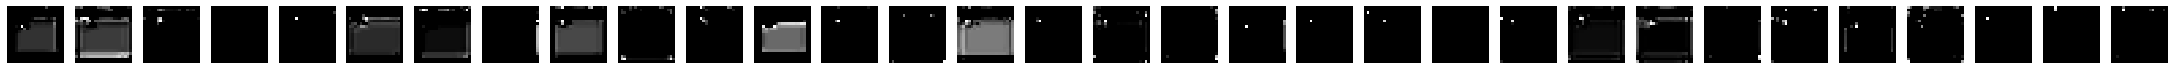

Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


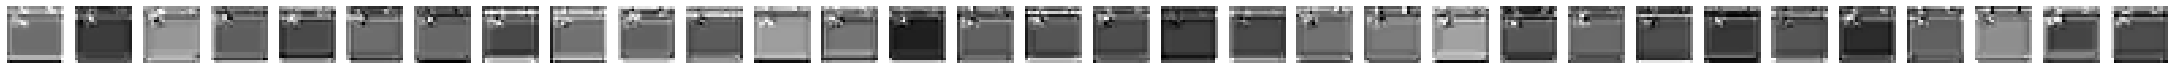

Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


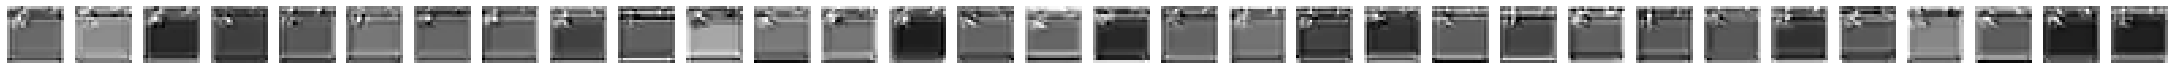

MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)


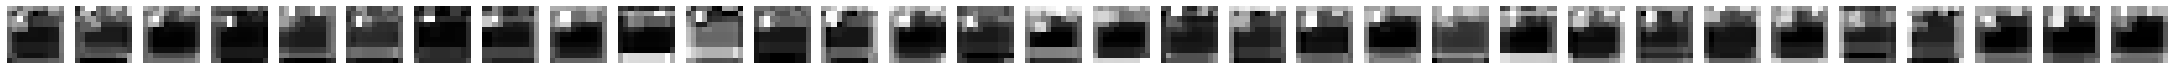

ReLU()


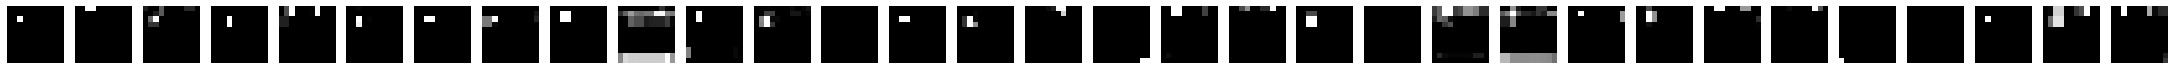

Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


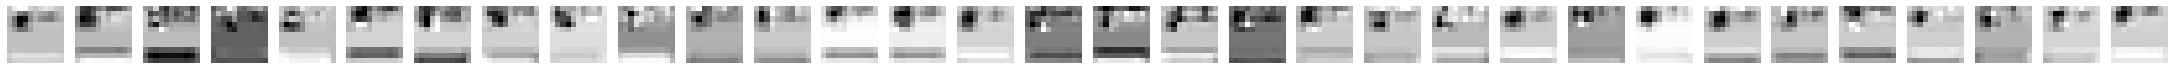

ReLU()


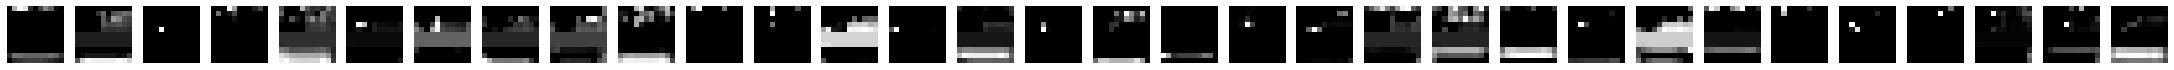

Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


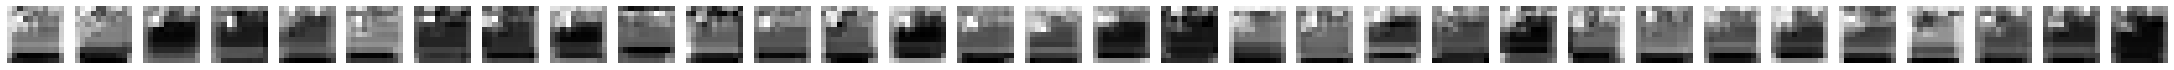

ReLU()


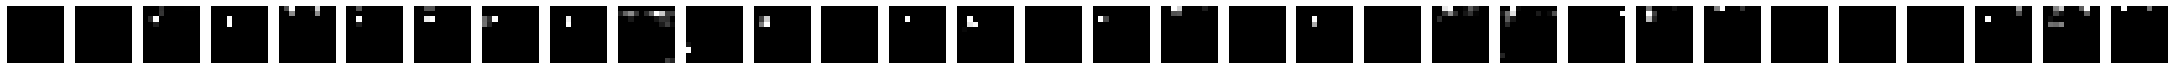

Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


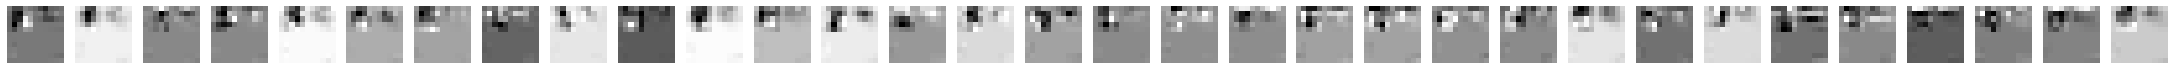

ReLU()


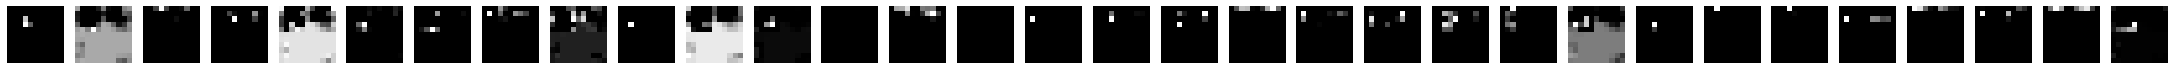

Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


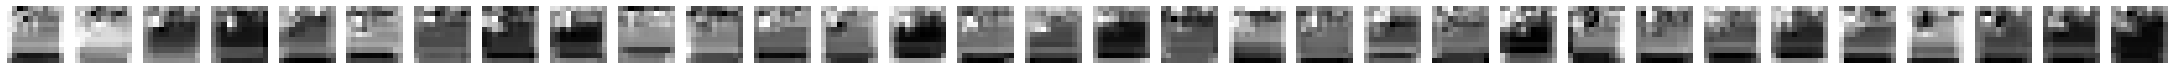

Linear(in_features=3872, out_features=256, bias=True)
Linear(in_features=257, out_features=6, bias=True)
PopArtLayer()


AttributeError: 'list' object has no attribute 'detach'

In [223]:
for item in visualisation.items():
    print(item[0])
    if not str(item[0]).startswith("Linear"):
        custom_viz(item[1].detach().clone())

In [233]:
torch.manual_seed(1)
inputs = dict()
inputs["frame"] = torch.randn(1, 1, 4, 84, 84)
inputs["reward"] = torch.randn(1, 1, 1)

model = Net(num_actions=6, num_tasks=1, use_lstm=False, use_popart=False, reward_clipping="abs_one")
y = model(inputs, torch.tensor)

g1 = make_dot(y[0][1], params=model.state_dict())
g2 = make_dot(y[0][3], params=model.state_dict())
g1.view()
#g2.view()

[DEBUG:55127 files:165 2020-01-02 21:02:28,616] write 7228 bytes to 'Digraph.gv'
[DEBUG:55127 backend:154 2020-01-02 21:02:28,618] run ['dot', '-Tpdf', '-O', 'Digraph.gv']
[DEBUG:55127 backend:278 2020-01-02 21:02:28,958] view: ['open', 'Digraph.gv.pdf']


'Digraph.gv.pdf'